In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import shap
from scipy.stats import pearsonr
from sklearn.model_selection import KFold
from plot_functions import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams["figure.dpi"] = 500

In [3]:
yld_df = pd.read_csv("Data/yield_model_data.csv").drop("Unnamed: 0", axis =1)
# irrig_df = pd.read_csv("Data/irrig_model_data.csv")
yld_df

Reported_Yield  Year FieldID  MinTemp_mean  MaxTemp_mean          GDD  \
0        12.428670  2016     NB1      6.106788     22.029015  1644.890021   
1        10.184502  2017     NB1      5.822711     21.877106  1614.254973   
2        13.101181  2018     NB1      4.975202     20.631099  1644.100009   
3         8.171677  2020     NB1      5.105658     21.794927  1624.754994   
4        10.247718  2021     NB1      5.365971     21.024176  1718.870071   
..             ...   ...     ...           ...           ...          ...   
84       10.427278  2010     NW5      5.358873     21.483788  1678.094235   
85        7.873083  2011     NW5      5.241023     23.079517  1703.116681   
86        8.400331  2012     NW5      7.137018     25.398542  1742.358807   
87       12.098467  2013     NW5      5.163082     22.073193  1677.740152   
88       12.547705  2014     NW5      4.273169     21.045244  1576.573520   

        NDVI  NDVI_Aug      ET_sum       vpd  Precip_sum  ReferenceET_sum  \
0   0.651859  0.603531  676.170587  1.781269  544.150002      1139.259996   
1   0.660628  0.823997  648.051550  1.951652  535.800001      1148.359997   
2   0.714815  0.856244  696.440038  1.620673  443.960002      1130.510002   
3   0.587987  0.759675  656.890253  1.925848  331.310000      1218.569996   
4   0.660427  0.769854  630.049208  1.791752  438.000001      1166.679999   
..       ...       ...         ...       ...         ...              ...   
84  0.632124  0.848636  680.589186  1.811286  500.463421      1190.294696   
85  0.599659  0.809075  645.507771  2.356133  513.787253      1253.859250   
86  0.571647  0.599178  733.643316  2.941741  280.576171      1442.532989   
87  0.632650  0.847245  789.115758  2.253056  412.144595      1189.272089   
88  0.703722  0.875978  717.465433  1.716567  475.758355      1150.068530   

    Tmp_excede33  Percent_Slope  Precip_deficit  
0             33          5.472      132.020586  
1             33          5.472      112.251549  
2             29          5.472      252.480036  
3             43          5.472      325.580253  
4             43          5.472      192.049207  
..           ...            ...             ...  
84            47          4.025      180.125765  
85            65          4.025      131.720518  
86            65          4.025      453.067145  
87            52          4.025      376.971163  
88            32          4.025      241.707078  

[89 rows x 15 columns]

In [4]:
yld_df.describe()

Reported_Yield         Year  MinTemp_mean  MaxTemp_mean          GDD  \
count       89.000000    89.000000     89.000000     89.000000    89.000000   
mean        11.558373  2015.539326      5.479933     21.954169  1663.017055   
std          2.732363     4.290730      0.848627      1.257537    70.488590   
min          4.621493  2008.000000      4.229268     19.945606  1475.545154   
25%         10.068158  2012.000000      5.000183     21.045244  1623.149896   
50%         12.074257  2016.000000      5.253383     21.877106  1675.893091   
75%         13.296209  2019.000000      5.895191     22.367288  1704.757703   
max         18.527670  2022.000000      7.920596     25.406386  1851.952304   

            NDVI   NDVI_Aug      ET_sum        vpd  Precip_sum  \
count  89.000000  89.000000   89.000000  89.000000   89.000000   
mean    0.652910   0.810793  702.443985   1.931508  462.087980   
std     0.067188   0.082561   51.870033   0.386805  111.843583   
min     0.514084   0.523538  570.474861   1.259735  247.429999   
25%     0.606542   0.807752  671.172069   1.684590  394.000001   
50%     0.649018   0.843348  694.631879   1.819380  489.789186   
75%     0.712067   0.859017  741.531424   2.210737  538.040242   
max     0.822295   0.892537  829.937171   2.941741  652.299996   

       ReferenceET_sum  Tmp_excede33  Percent_Slope  Precip_deficit  
count        89.000000     89.000000      89.000000       89.000000  
mean       1189.439445     41.797753       4.093337      240.356005  
std          96.504577     13.356289       0.789117      131.164211  
min        1020.008096     14.000000       2.416000      -25.113995  
25%        1148.359997     32.000000       3.796000      136.927910  
50%        1165.082234     43.000000       4.025000      236.800576  
75%        1218.166020     49.000000       4.866000      320.343176  
max        1445.517576     65.000000       5.472000      523.730026

### XGBoost model random split- hyperparameter tuning

In [5]:
X_xgb = yld_df.iloc[:,3:] #independent variables
Y_xgb = yld_df["Reported_Yield"] # target


X_train, X_test, y_train, y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=153)

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# hyperparameters

# param_grid = {
#     'n_estimators': [ 50,100, 200,500],
#     'max_depth': [ 2,3,5],
#     'learning_rate': [ 0.1,.2],
#     'subsample': [.8, 0.9],
#     'colsample_bytree': [  .5, .8, .9],
#     'gamma': [ .2, .4, .5,.6],
#     "reg_alpha": [.1,.2,.3]
# }

# now best params found
param_grid = {
    'n_estimators': [50],
    'max_depth': [2],
    'learning_rate': [0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'gamma': [0.6],
    'reg_alpha': [0.4]
}


# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor()


# Perform grid search with 10-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
grid_search.fit(X_train, y_train)



# # # Print the best parameters
best_params_xgb = grid_search.best_params_
print(f'Best Parameters for XGBoost: {best_params_xgb}')

# # Train the XGBoost model with the best parameters
best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
best_yld_xgb_model.fit(X_train, y_train)



y_pred_xgb = best_yld_xgb_model.predict(X_test)
y_pred_train_xgb = best_yld_xgb_model.predict(X_train)

# Calculate and print the Mean Absolute Error on the test set
mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'Mean Absolute Error on Test Set (XGBoost): {mae_test_xgb}')

# Calculate and print R2 score on the test set
r2_test_xgb = r2_score(y_test, y_pred_xgb)
print(f'R2 Score on Test Set (XGBoost): {r2_test_xgb:.4f}')


mae_train_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
print(f'Mean Absolute Error on Training Set (XGBoost): {mae_train_xgb}')

# Calculate and print R2 score on the training set
r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
print(f'R2 Score on Training Set (XGBoost): {r2_train_xgb:.4f}')




Best Parameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0.6, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.4, 'subsample': 0.9}
Mean Absolute Error on Test Set (XGBoost): 0.7133076954064399
R2 Score on Test Set (XGBoost): 0.8872
Mean Absolute Error on Training Set (XGBoost): 0.4247421581273794
R2 Score on Training Set (XGBoost): 0.9593


### in a single random split finding best rendom state/split

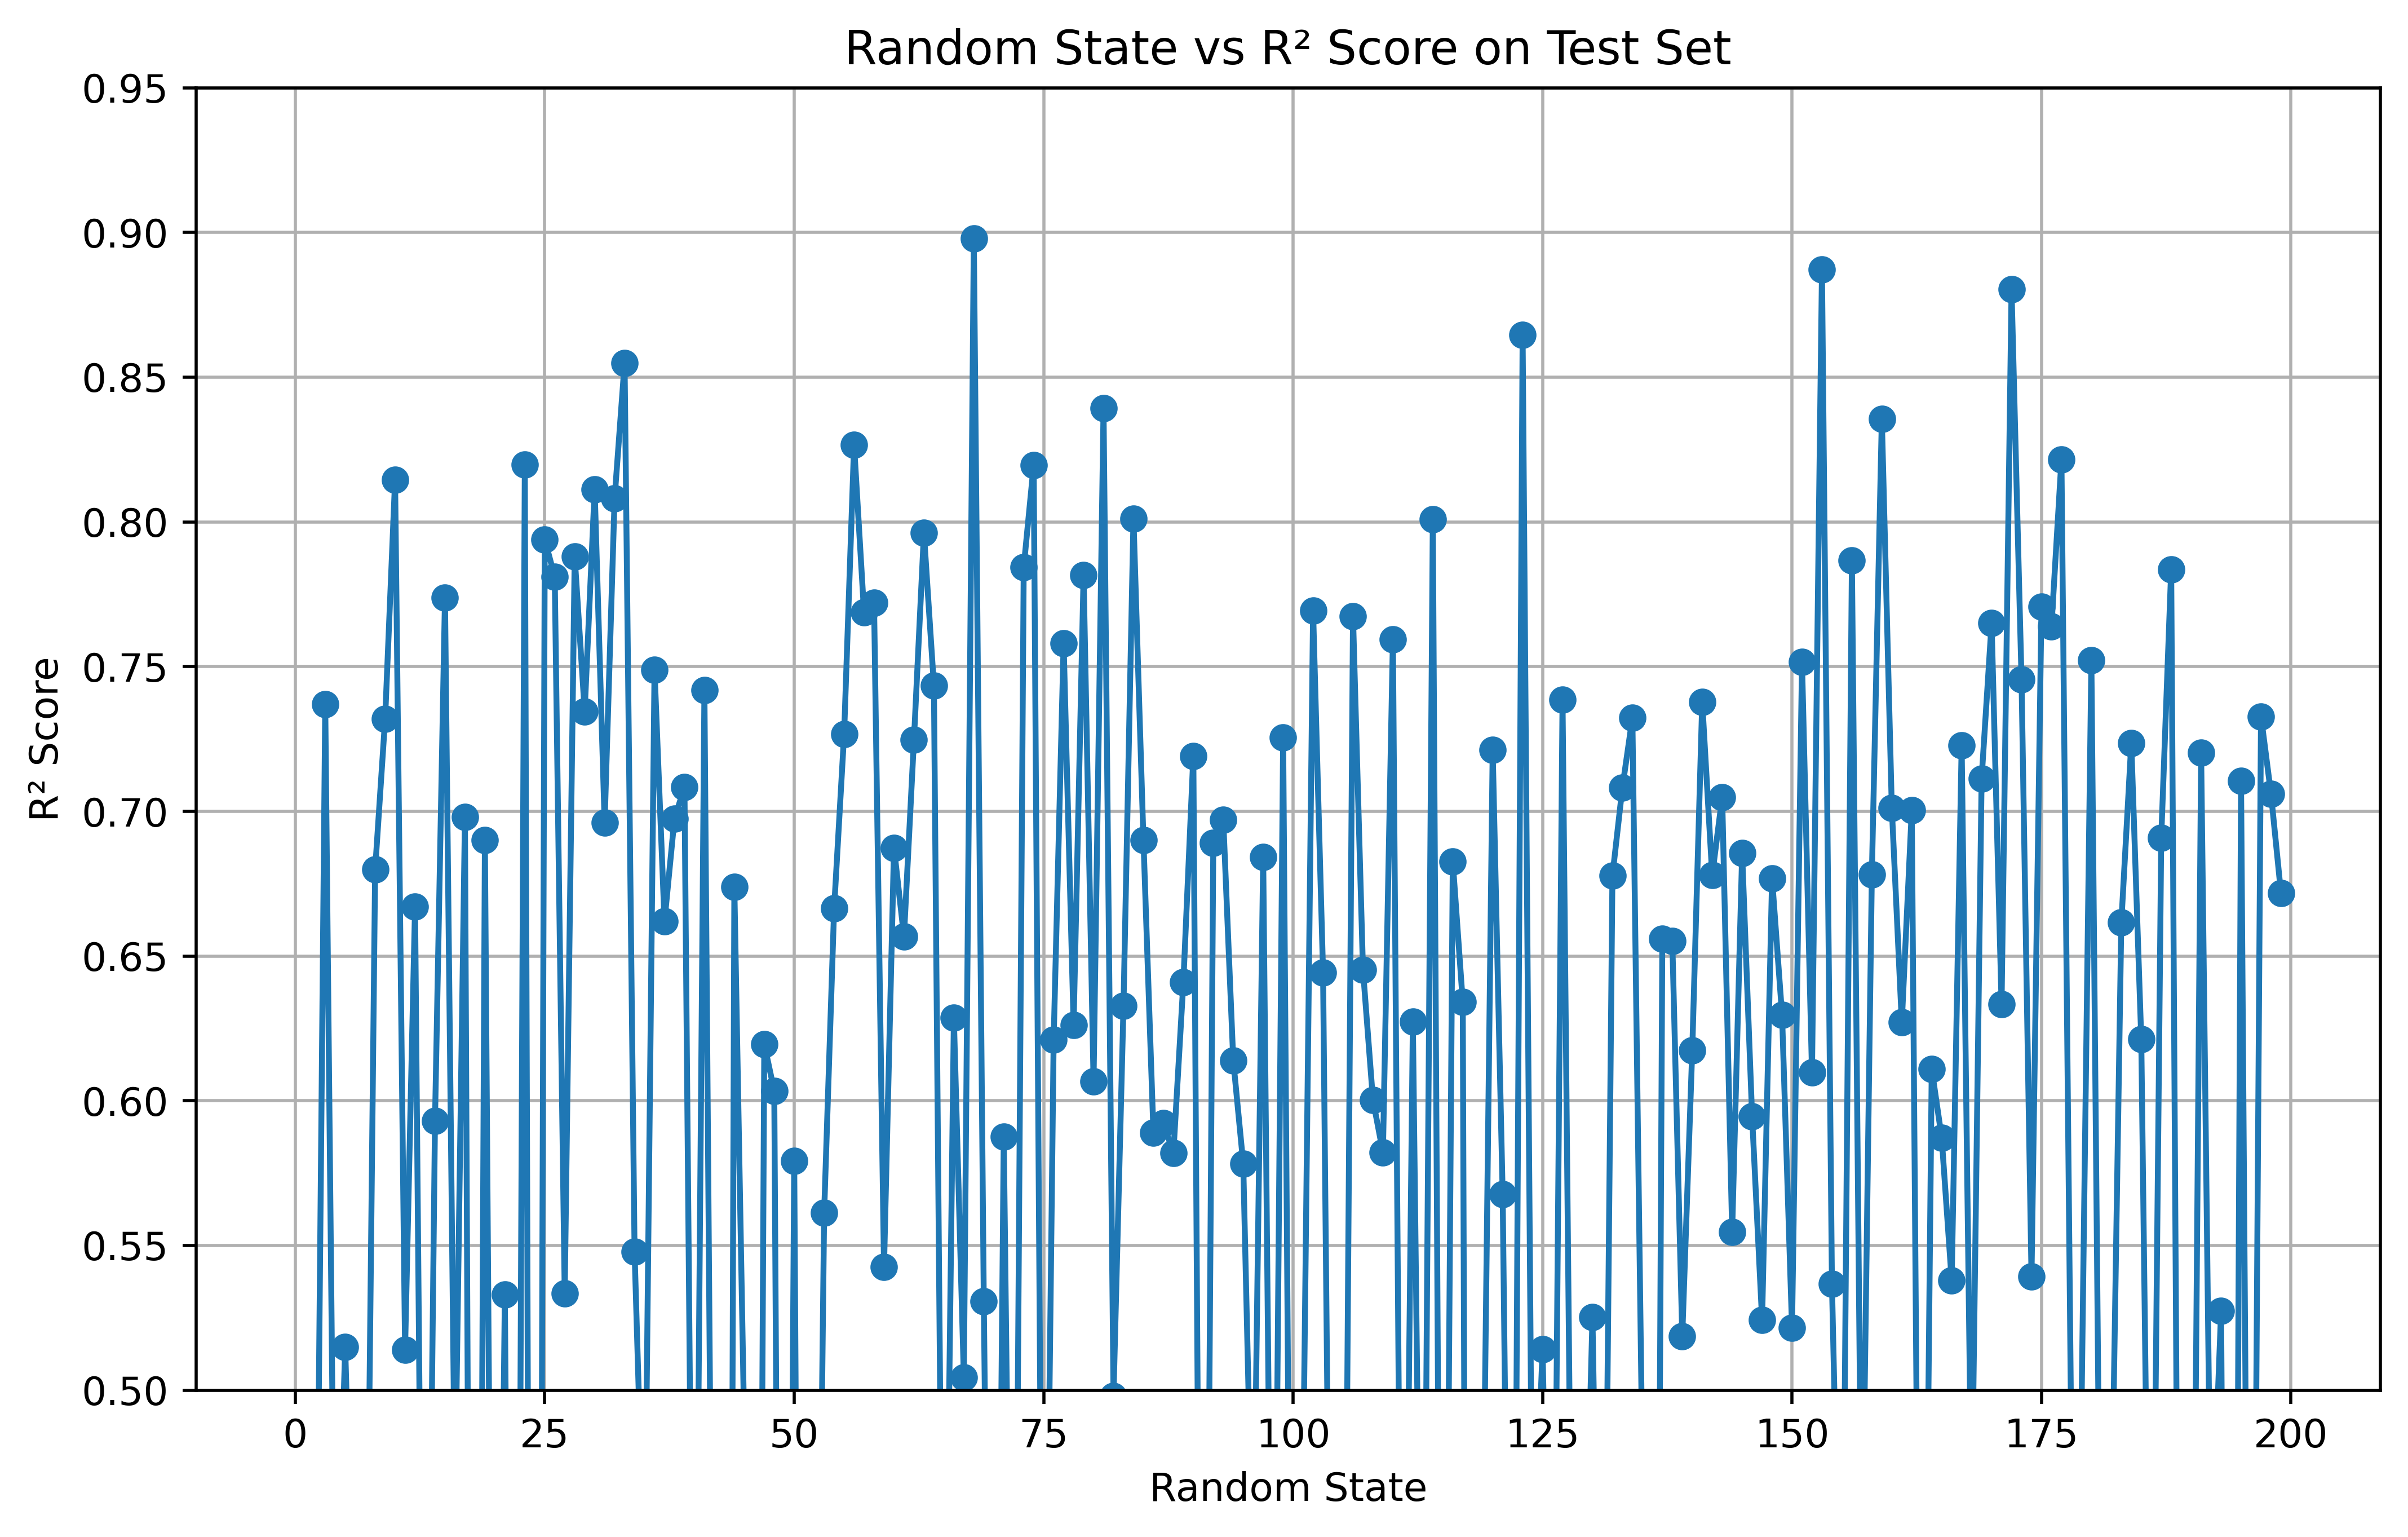

In [32]:
random_states = []
r2_scores = []

# Loop over 100 random states
for random_state in range(0, 200):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_xgb, Y_xgb, test_size=0.2, random_state=random_state)
    
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    best_params_xgb = grid_search.best_params_
    
    # Train best model
    best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
    best_yld_xgb_model.fit(X_train, y_train)
    
    # Predict and calculate R2 on test set
    y_pred_xgb = best_yld_xgb_model.predict(X_test)
    r2_test_xgb = r2_score(y_test, y_pred_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
    
    # Store results
    random_states.append(random_state)
    r2_scores.append(r2_test_xgb)

# Plotting Random State vs R2
plt.figure(figsize=(10, 6))
plt.plot(random_states, r2_scores, marker='o')
plt.xlabel('Random State')
plt.ylim(.5,.95)
plt.ylabel('R² Score')
plt.title('Random State vs R² Score on Test Set')
plt.grid(True)
plt.show()


In [33]:
# Convert to numpy array (if not already)
r2_scores_array = np.array(r2_scores)

# Get indices of top 5 highest R2 scores
top5_indices = np.argsort(r2_scores_array)[-5:][::-1]  # sort, pick last 5, then reverse

# Get the corresponding random states and R2 values
top5_random_states = [random_states[i] for i in top5_indices]
top5_r2_scores = [r2_scores[i] for i in top5_indices]

# Print them
for rs, r2 in zip(top5_random_states, top5_r2_scores):
    print(f'Random State: {rs}, R² Score: {r2:.4f}')

Random State: 68, R² Score: 0.8978
Random State: 153, R² Score: 0.8872
Random State: 172, R² Score: 0.8803
Random State: 123, R² Score: 0.8645
Random State: 33, R² Score: 0.8549


## 5 Random CV

In [25]:

def run_xgb_kfold(X, y, n_splits=5, random_state=153, params=None):
    """
    Run XGBoost regression with KFold CV.
    
    Returns:
        results_df: DataFrame with columns:
                    ['Fold', 'Set', 'Actual', 'Predicted']
        metrics_df: DataFrame with MAE and R2 per fold
    """
    if params is None:
        params = {
            'n_estimators': 50,
            'max_depth': 2,
            'learning_rate': 0.2,
            'subsample': 0.9,
            'colsample_bytree': 0.7,
            'gamma': 0.6,
            'reg_alpha': 0.4,
            'random_state': random_state
        }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = []
    metrics = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit model
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Save results
        results.extend([
            pd.DataFrame({
                'Fold': fold,
                'Set': 'Train',
                'Actual': y_train,
                'Predicted': y_train_pred
            }),
            pd.DataFrame({
                'Fold': fold,
                'Set': 'Test',
                'Actual': y_test,
                'Predicted': y_test_pred
            })
        ])

        # Save metrics
        metrics.append({
            'Fold': fold,
            'Train_MAE': mean_absolute_error(y_train, y_train_pred),
            'Test_MAE': mean_absolute_error(y_test, y_test_pred),
            'Train_R2': r2_score(y_train, y_train_pred),
            'Test_R2': r2_score(y_test, y_test_pred)
        })

    results_df = pd.concat(results, ignore_index=True)
    metrics_df = pd.DataFrame(metrics)
    return results_df, metrics_df




In [26]:
X_xgb = yld_df.iloc[:,3:]
Y_xgb = yld_df["Reported_Yield"]
results_df, metrics_df = run_xgb_kfold(X_xgb, Y_xgb)
cv5results = results_df
results_df

Fold    Set     Actual  Predicted
0       1  Train  12.428670  11.932896
1       1  Train  10.184502  10.284702
2       1  Train  13.101181  13.544265
3       1  Train   8.171677   8.050550
4       1  Train  10.247718   9.760721
..    ...    ...        ...        ...
440     5   Test  12.138146  10.484765
441     5   Test   6.129935   9.225837
442     5   Test  11.550371  11.585516
443     5   Test  12.074257  11.198233
444     5   Test   9.378162   9.709241

[445 rows x 4 columns]

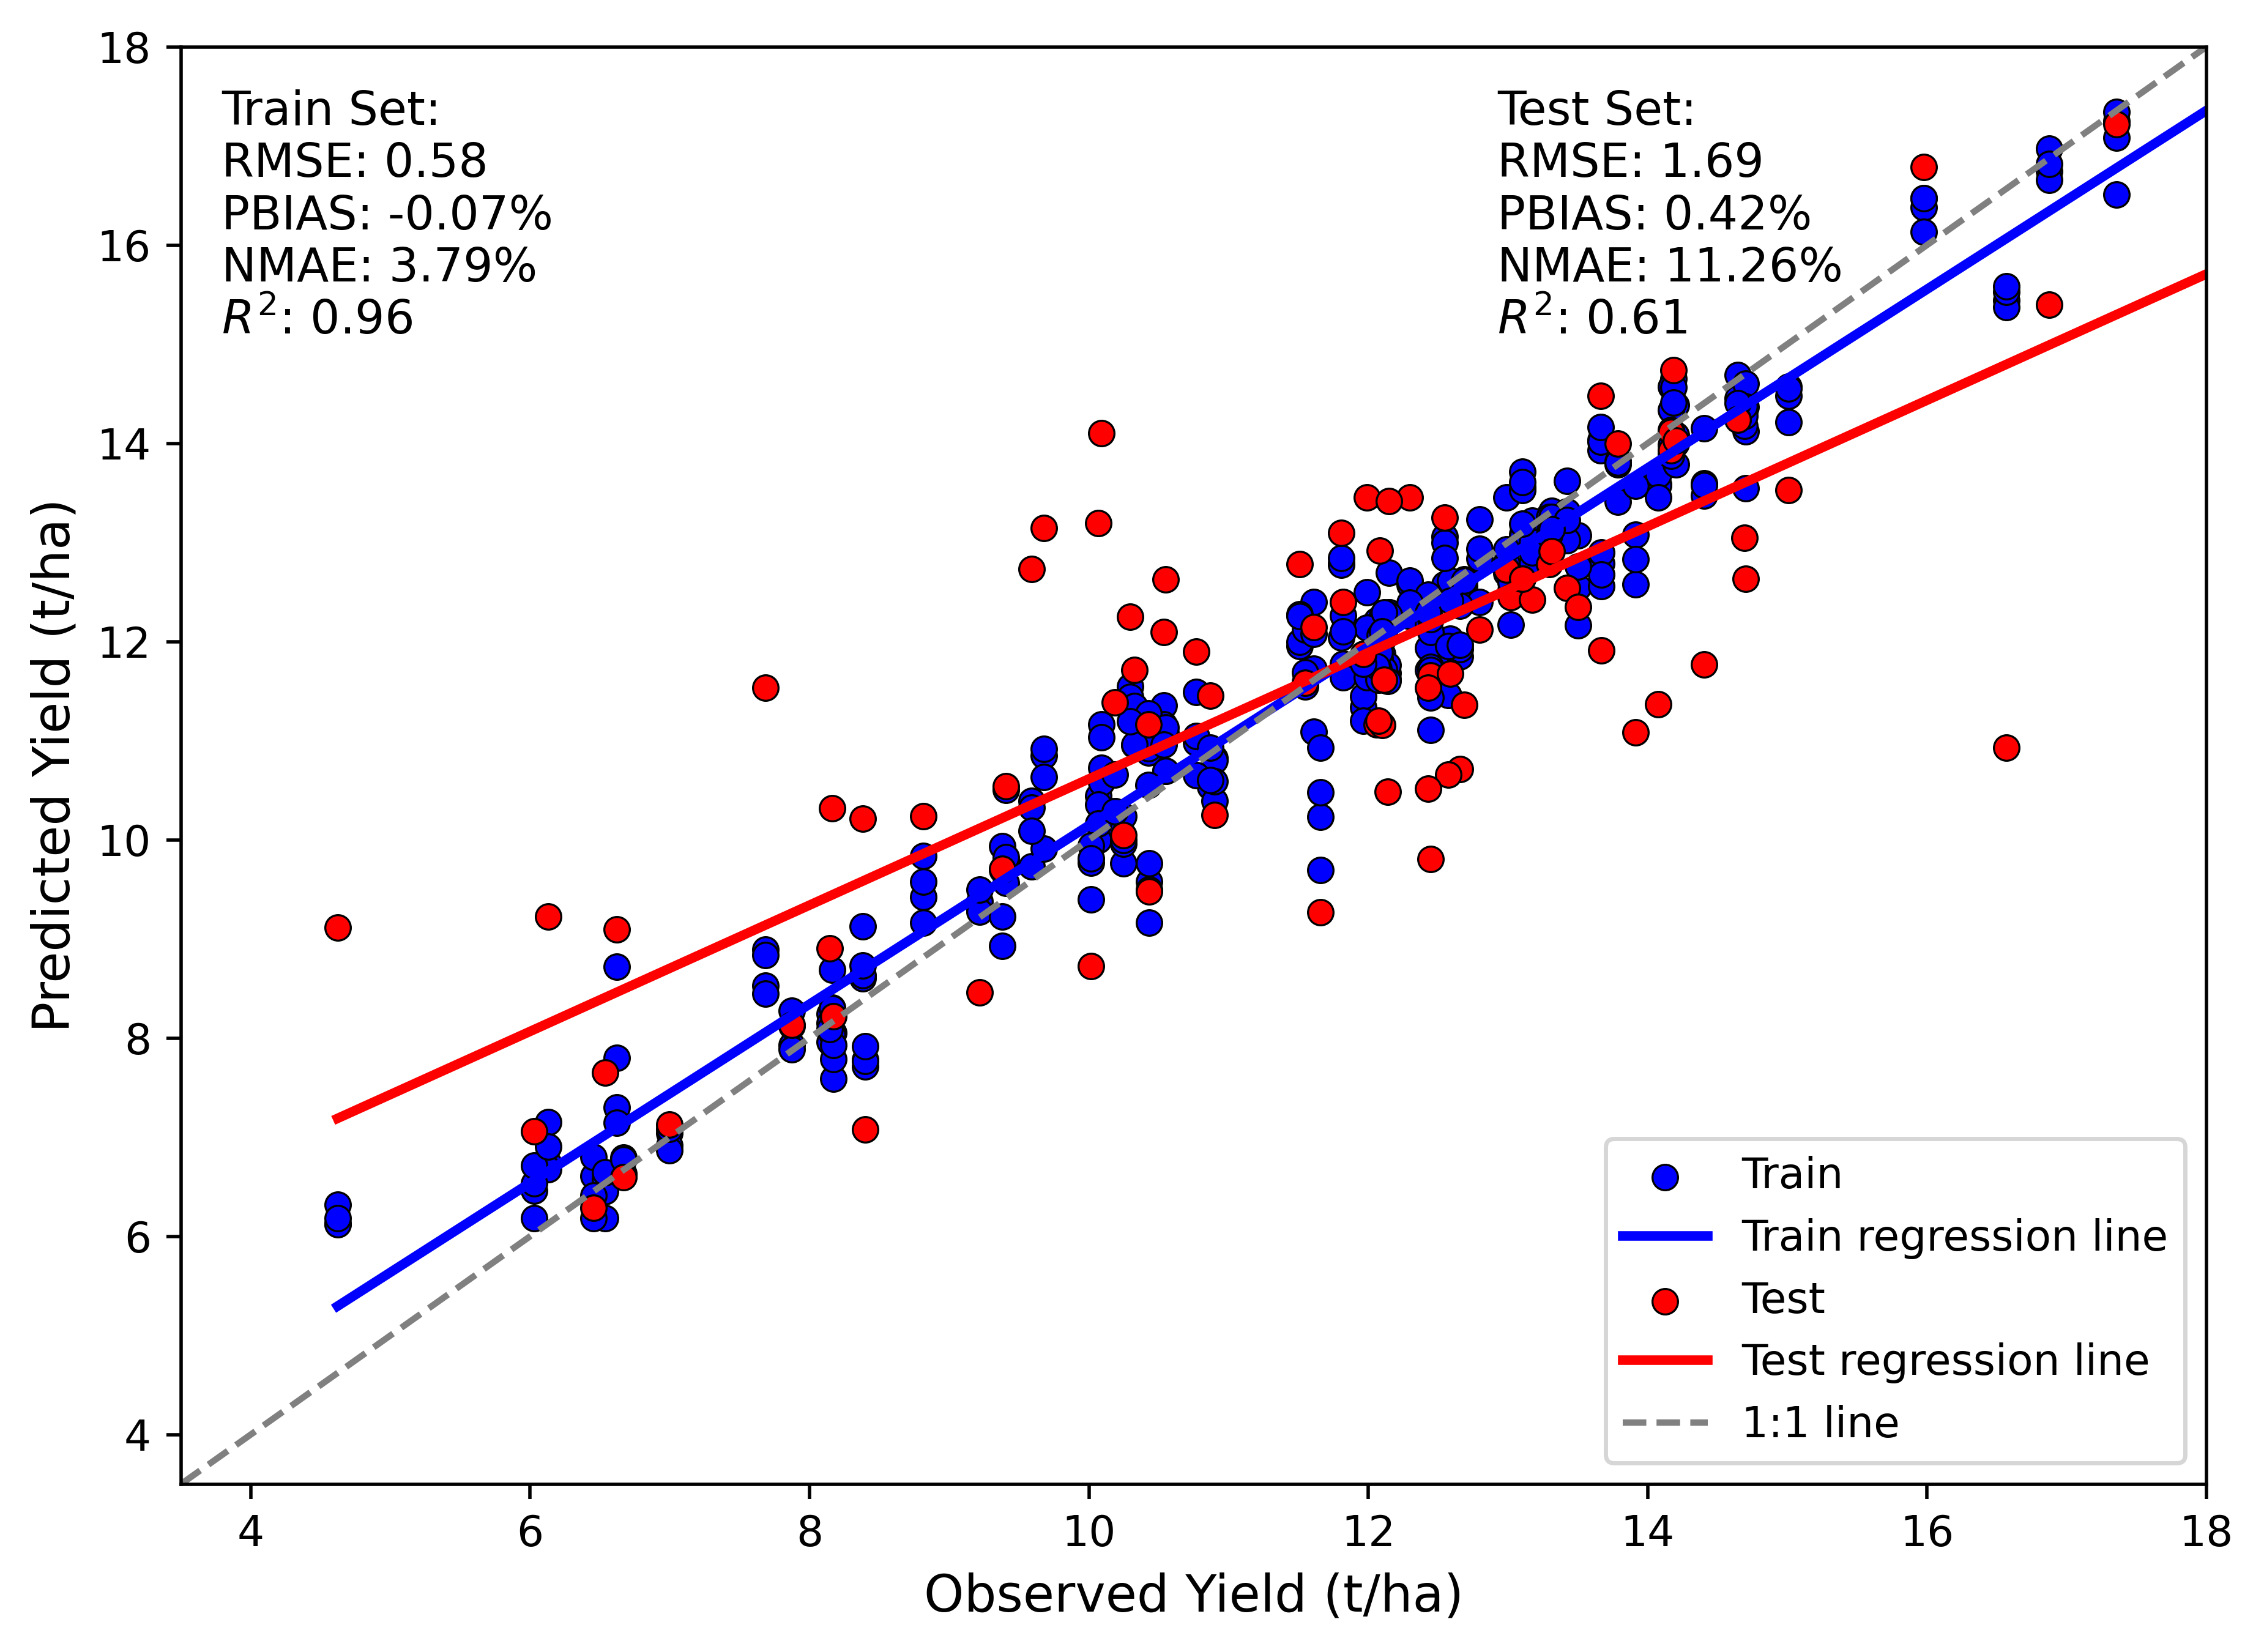

In [22]:
evaluate_model(
    y_train=results_df.loc[results_df["Set"] == "Train", "Actual"],
    y_pred_train=results_df.loc[results_df["Set"] == "Train", "Predicted"],
    y_test = results_df.loc[results_df["Set"] == "Test", "Actual"],
    y_pred_test = results_df.loc[results_df["Set"] == "Test", "Predicted"],
    units='t/ha',
    text = "Test Set",
    label = "",
#     hue =results_df["Fold"],
    xlabel = "Observed Yield", ylabel = "Predicted Yield",
    p= .50,
    legend_outside=False
)


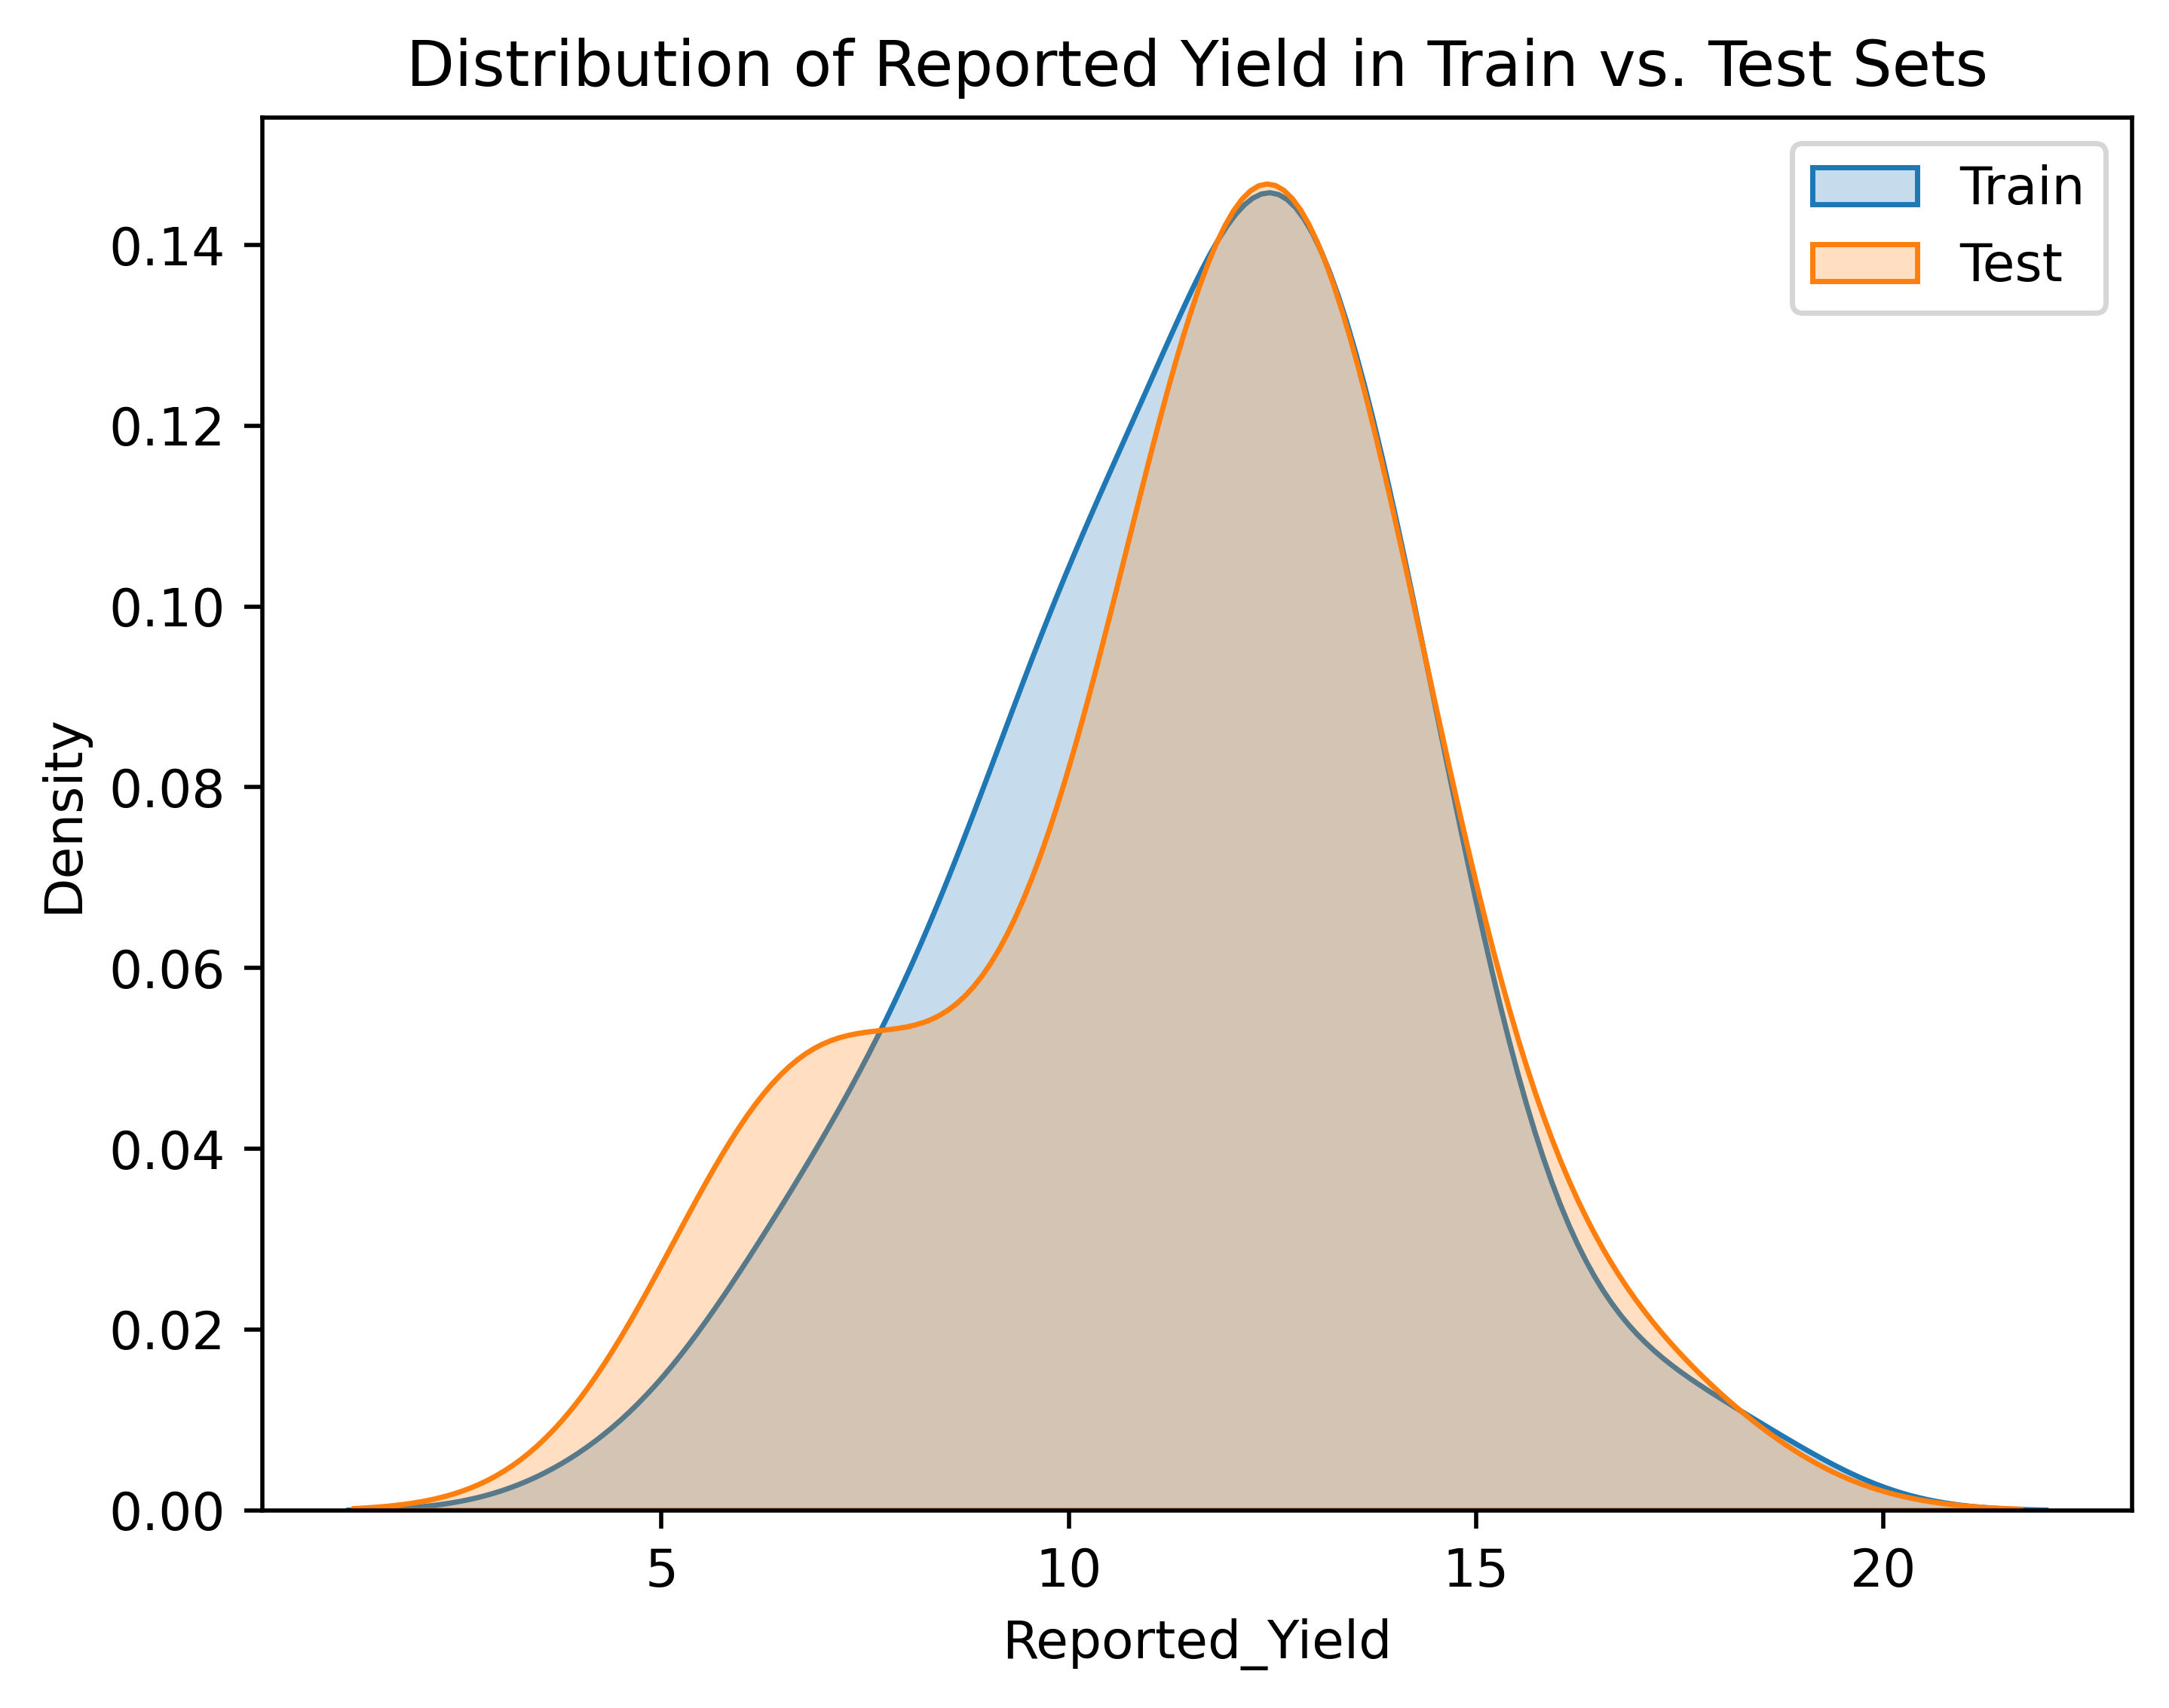

In [10]:
sns.kdeplot(y_train, label="Train", shade=True)
sns.kdeplot(y_test, label="Test", shade=True)
plt.legend()
plt.title("Distribution of Reported Yield in Train vs. Test Sets")
plt.show()

# Holdout tests

In [11]:
def evaluate_xgboost_holdout(
    df,
    feature_start_col: int = 3,
    target_col: str = "Reported_Yield",
    group_col: str = "Year",  
    param_grid: dict = None,
    random_state: int = 151,
    test_size: float = 0.2,
    use_test_split: bool = False,
    filter_features: bool = False,
    selected_features: list = None,
    skip_single_fields: bool = True
):
    """
    Evaluate XGBoost using a group-based holdout approach.

    For each unique value in `group_col`, that group is used as the holdout set,
    while the remaining data is used to train the model. Optionally performs 
    a train/test split within the training set. Results are collected for 
    training, test (if used), and holdout predictions.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset containing features, target, and grouping column.

    feature_start_col : int, default=3
        Column index from which feature columns start (if not using selected_features).

    target_col : str, default="Reported_Yield"
        Name of the target column.

    group_col : str, default="Year"
        Column name used for grouping the holdout (e.g., "Year" or "FieldID").

    param_grid : dict, optional
        Parameter grid for GridSearchCV. If None, a default small grid is used.

    random_state : int, default=151
        Random seed for reproducibility.

    test_size : float, default=0.2
        Proportion of data to use for test split when use_test_split=True.

    use_test_split : bool, default=False
        If True, split the training set into train/test. Otherwise, use all non-holdout data for training.

    filter_features : bool, default=False
        If True, use only selected_features for training. Otherwise, use all columns after feature_start_col.

    selected_features : list, optional
        List of feature names to use if filter_features=True.

    skip_single_fields : bool, default=True
        If True, skip groups (by group_col) that have 1 or fewer samples.
        If False, include them in evaluation, but note results may be unstable.

    Returns
    -------
    train_df : pd.DataFrame
        Predictions vs actuals for training data.

    test_df : pd.DataFrame or None
        Predictions vs actuals for test data (if use_test_split=True).

    holdout_df : pd.DataFrame
        Predictions vs actuals for each holdout group.
    """

    # --- Feature & target selection ---
    if filter_features and selected_features is not None:
        X_full = df[selected_features]
    else:
        X_full = df.iloc[:, feature_start_col:]

    y_full = df[target_col]
    groups = df[group_col]

    # --- Default parameter grid if not provided ---
    if param_grid is None:
        param_grid = {
            'n_estimators': [50],
            'max_depth': [2],
            'learning_rate': [0.2],
            'subsample': [0.9],
            'colsample_bytree': [0.7],
            'gamma': [0.6],
            'reg_alpha': [0.4]
        }

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    xgb_regressor = xgb.XGBRegressor()

    holdout_results, train_results, test_results = [], [], []

    # --- Loop over unique groups ---
    unique_values = df[group_col].unique()

    for val in unique_values:
        mask = (groups == val)

        # Optionally skip very small sets
        if skip_single_fields and mask.sum() <= 1:
            print(f"Skipping {group_col}={val} (only {mask.sum()} samples).")
            continue

        # Define holdout and training sets
        X_holdout = X_full[mask]
        y_holdout = y_full[mask]
        X_rest = X_full[~mask]
        y_rest = y_full[~mask]

        print(f"\n=== Holdout {group_col}: {val} ({mask.sum()} samples) ===")

        if use_test_split:
            X_train, X_test, y_train, y_test = train_test_split(
                X_rest, y_rest, test_size=test_size, random_state=random_state
            )
        else:
            X_train, y_train = X_rest, y_rest
            X_test, y_test = None, None

        # --- Hyperparameter search ---
        grid_search = GridSearchCV(
            estimator=xgb_regressor,
            param_grid=param_grid,
            scoring=mae_scorer,
            cv=5,
            n_jobs=8
        )
        grid_search.fit(X_train, y_train)

        best_model = xgb.XGBRegressor(**grid_search.best_params_)
        best_model.fit(X_train, y_train)

        # --- Predictions ---
        y_pred_train = best_model.predict(X_train)
        y_pred_holdout = best_model.predict(X_holdout)

        holdout_mae = mean_absolute_error(y_holdout, y_pred_holdout)
        holdout_pbias_val = pbias(y_pred_holdout, y_holdout)
        holdout_r2 = r2_score(y_holdout, y_pred_holdout)

        print(f"Holdout MAE: {holdout_mae:.4f}")
        print(f"Holdout PBIAS: {holdout_pbias_val:.2f}%")
        print(f"Holdout R2: {holdout_r2:.2f}")

        # --- Store results ---
        holdout_results.extend([
            {"Actual": a, "Predicted": p, group_col: str(val)}
            for a, p in zip(y_holdout, y_pred_holdout)
        ])
        train_results.extend([
            {"Actual": a, "Predicted": p, group_col: str(val)}
            for a, p in zip(y_train, y_pred_train)
        ])
        if use_test_split:
            y_pred_test = best_model.predict(X_test)
            test_results.extend([
                {"Actual": a, "Predicted": p, group_col: str(val)}
                for a, p in zip(y_test, y_pred_test)
            ])

    # --- Convert to DataFrames ---
    holdout_df = pd.DataFrame(holdout_results)
    train_df = pd.DataFrame(train_results)
    test_df = pd.DataFrame(test_results) if use_test_split else None

    # --- Sort if group_col is Year ---
    if group_col == "Year":
        holdout_df = holdout_df.sort_values(by="Year").reset_index(drop=True)

    return train_df, test_df, holdout_df


In [12]:
train_results, test_results,holdout_results = evaluate_xgboost_holdout(
                            df=yld_df,
                            target_col="Reported_Yield",
                            group_col = "Year",
                            use_test_split = False,
                        )

yld_hld_yr= holdout_results #string that result in a new variable


=== Holdout Year: 2016 (6 samples) ===
Holdout MAE: 1.2159
Holdout PBIAS: 3.80%
Holdout R2: 0.33

=== Holdout Year: 2017 (6 samples) ===
Holdout MAE: 1.3447
Holdout PBIAS: -3.39%
Holdout R2: 0.47

=== Holdout Year: 2018 (6 samples) ===
Holdout MAE: 0.9792
Holdout PBIAS: -4.59%
Holdout R2: 0.16

=== Holdout Year: 2020 (7 samples) ===
Holdout MAE: 2.3534
Holdout PBIAS: -9.66%
Holdout R2: 0.46

=== Holdout Year: 2021 (7 samples) ===
Holdout MAE: 2.3570
Holdout PBIAS: -16.35%
Holdout R2: -0.14

=== Holdout Year: 2022 (8 samples) ===
Holdout MAE: 1.8510
Holdout PBIAS: 10.22%
Holdout R2: 0.58

=== Holdout Year: 2019 (5 samples) ===
Holdout MAE: 1.5888
Holdout PBIAS: -6.85%
Holdout R2: -0.23

=== Holdout Year: 2015 (6 samples) ===
Holdout MAE: 0.9648
Holdout PBIAS: 5.62%
Holdout R2: 0.06

=== Holdout Year: 2011 (5 samples) ===
Holdout MAE: 0.9385
Holdout PBIAS: -9.07%
Holdout R2: 0.64

=== Holdout Year: 2012 (7 samples) ===
Holdout MAE: 0.6997
Holdout PBIAS: 5.95%
Holdout R2: 0.82

=== Holdo

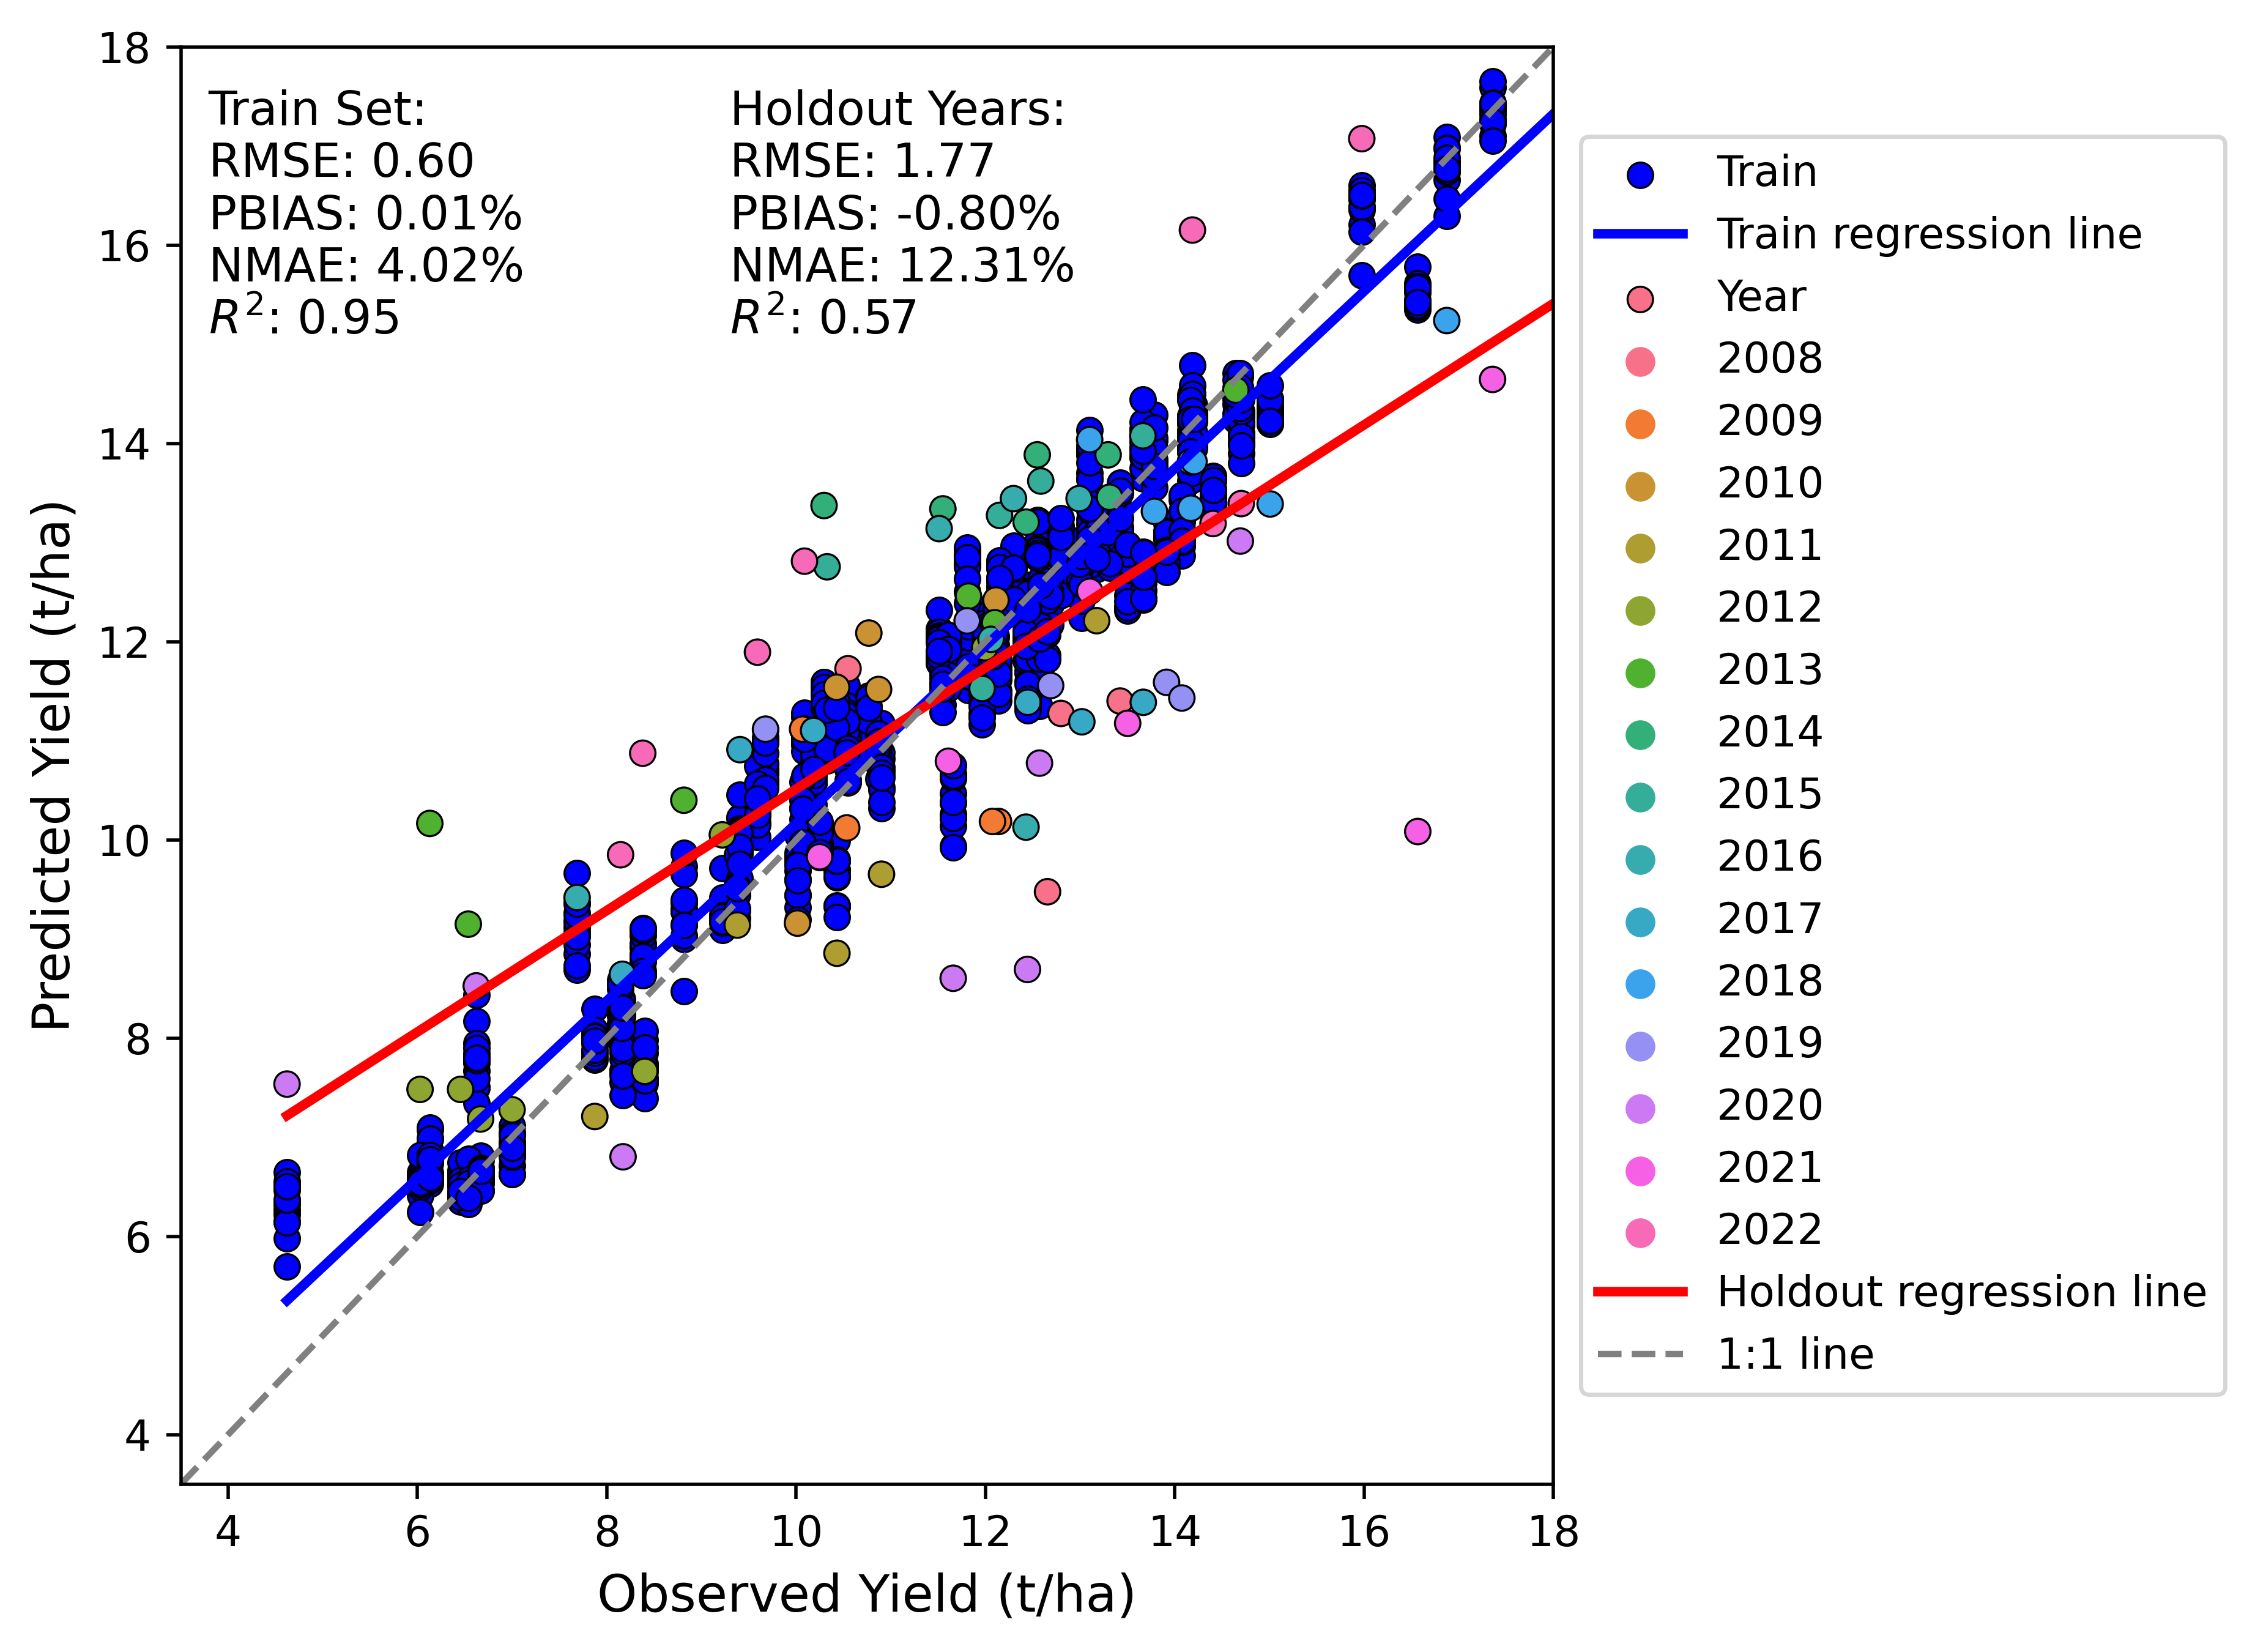

In [13]:
evaluate_model(
    y_train=train_results["Actual"], y_pred_train=train_results["Predicted"],
    y_holdout = holdout_results["Actual"], y_pred_holdout = holdout_results["Predicted"],
    units='t/ha',
    text = "Holdout Years",
    label = "Year",
    hue =holdout_results["Year"],
    xlabel = "Observed Yield", ylabel = "Predicted Yield",
    p= .40,
    legend_outside=True
    

)

In [14]:
# field holdout

train_results, test_results,holdout_results = evaluate_xgboost_holdout(
                            df=yld_df,
                            target_col="Reported_Yield",
                            group_col = "FieldID",
                            use_test_split = False
                        )

yld_hld_fid= holdout_results


=== Holdout FieldID: NB1 (11 samples) ===
Holdout MAE: 1.1111
Holdout PBIAS: -1.89%
Holdout R2: 0.67

=== Holdout FieldID: NC1 (2 samples) ===
Holdout MAE: 0.8005
Holdout PBIAS: -2.37%
Holdout R2: -0.67

=== Holdout FieldID: NC2 (2 samples) ===
Holdout MAE: 1.2867
Holdout PBIAS: -1.55%
Holdout R2: 0.63

=== Holdout FieldID: NW1 (12 samples) ===
Holdout MAE: 1.4758
Holdout PBIAS: 6.49%
Holdout R2: 0.49

=== Holdout FieldID: NW2 (14 samples) ===
Holdout MAE: 1.5237
Holdout PBIAS: 1.54%
Holdout R2: 0.26

=== Holdout FieldID: NW3 (12 samples) ===
Holdout MAE: 1.8472
Holdout PBIAS: 16.06%
Holdout R2: 0.30

=== Holdout FieldID: NW4 (14 samples) ===
Holdout MAE: 0.9930
Holdout PBIAS: -1.85%
Holdout R2: 0.57

=== Holdout FieldID: NW5 (13 samples) ===
Holdout MAE: 1.1710
Holdout PBIAS: -1.22%
Holdout R2: 0.63

=== Holdout FieldID: NW6 (3 samples) ===
Holdout MAE: 0.8178
Holdout PBIAS: -5.84%
Holdout R2: 0.82

=== Holdout FieldID: NW7 (6 samples) ===
Holdout MAE: 1.8715
Holdout PBIAS: -2.04%
Ho

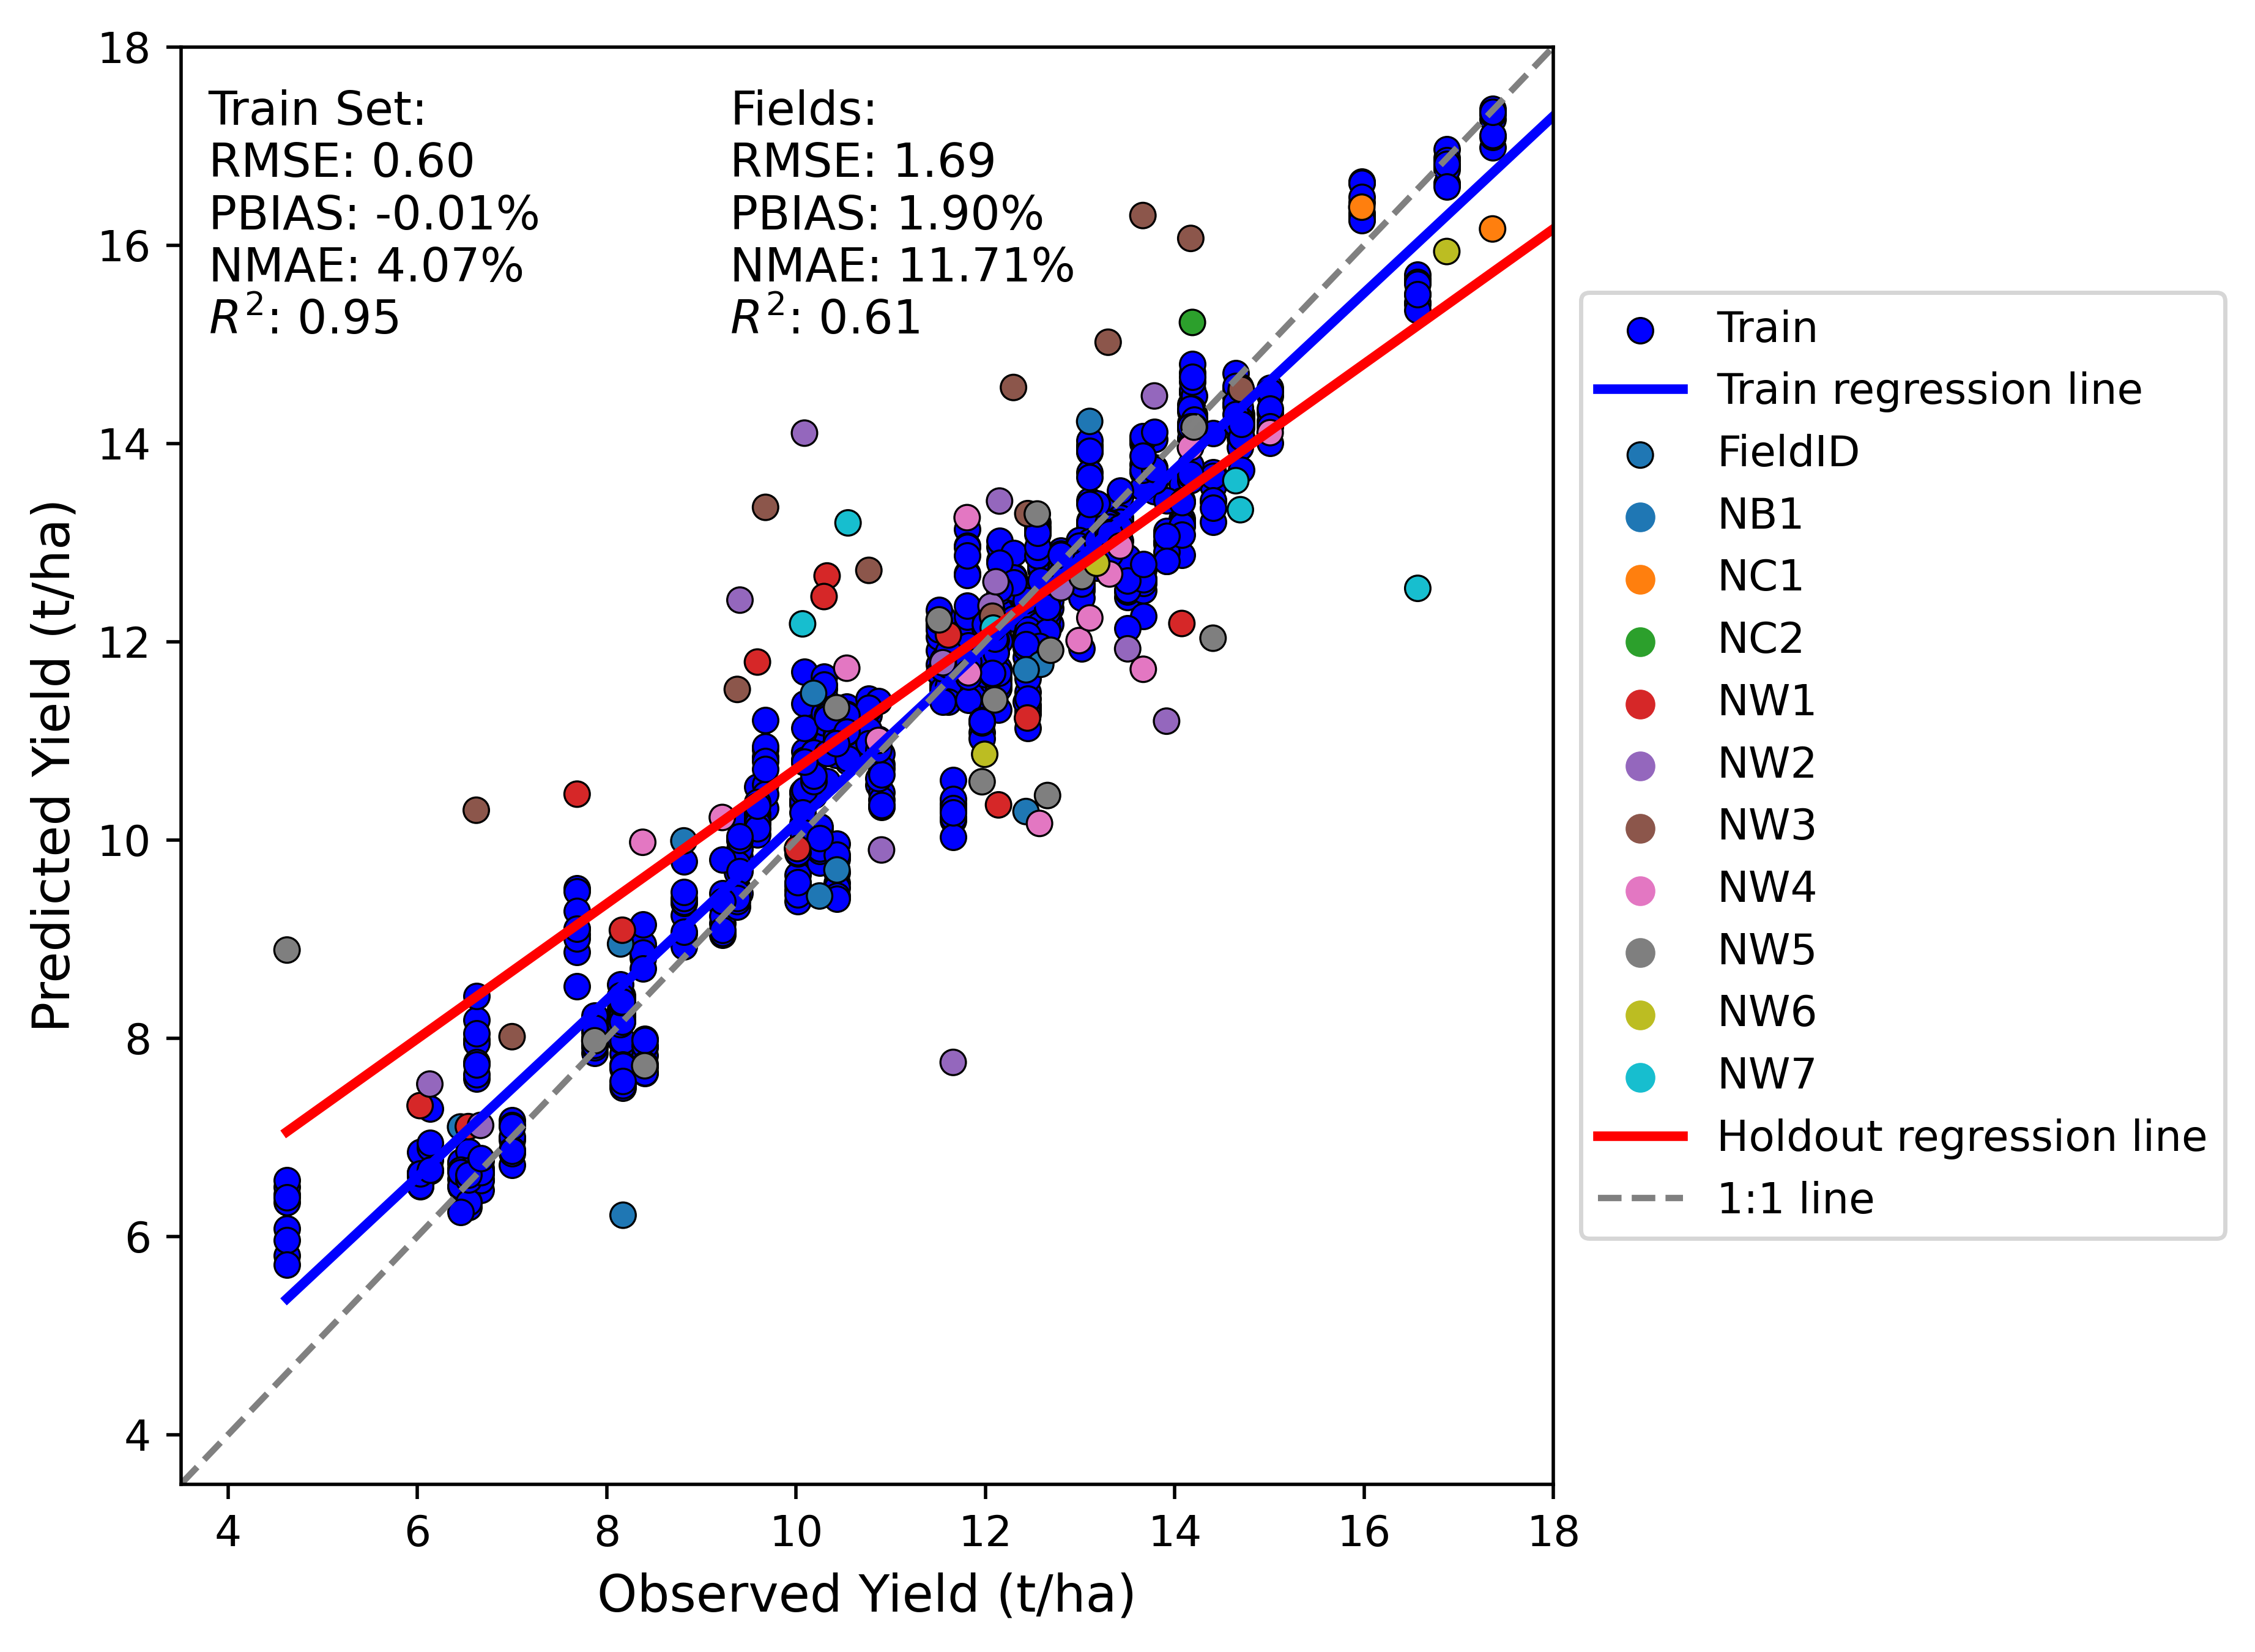

In [15]:
evaluate_model(
    y_train=train_results["Actual"], y_pred_train=train_results["Predicted"],
#     y_test=test_results["Actual"], y_pred_test=test_results["Predicted"],
    y_holdout = holdout_results["Actual"], y_pred_holdout = holdout_results["Predicted"],
    units='t/ha',
    text = "Fields",
    label ="FieldID",
    p=.40,
    xlabel = "Observed Yield", ylabel = "Predicted Yield",
    hue  =holdout_results["FieldID"],
    legend_outside=True
)

In [17]:
yld_hld_fid

Actual  Predicted FieldID
0   12.428670  10.285251     NB1
1   10.184502  11.478013     NB1
2   13.101181  14.221010     NB1
3    8.171677   6.212883     NB1
4   10.247718   9.433252     NB1
..        ...        ...     ...
84  16.567301  12.536871     NW7
85  10.548330  13.197355     NW7
86  10.068158  12.178723     NW7
87  12.082327  12.136025     NW7
88  14.645265  13.622845     NW7

[89 rows x 3 columns]

In [43]:
### Spatial and temporal Metric variation

In [16]:

def calculate_yearly_metrics(
    df,
    group_by_field=False,
    calculate_yield=True,
    calculate_irrigation=True,
    model=None,
    estimated="Simulated"
):
    """
    Calculate RMSE, PBIAS, and NMAE for yield and/or irrigation,
    grouped by Year or FieldID, and optionally tagged with a model name.

    Parameters:
    - df: DataFrame with required columns like:
        ['Year', 'FieldID', 'Reported_Yield', 'Simulated_Yield', ...]
    - group_by_field: Group by 'FieldID' instead of 'Year'
    - calculate_yield: Whether to calculate metrics for yield
    - calculate_irrigation: Whether to calculate metrics for irrigation
    - model: Optional string tag to label the model
    - estimated: Column prefix for simulated or predicted values (default: 'Simulated')

    Returns:
    - A tidy DataFrame with columns like:
        ['Year' or 'FieldID', 'Metric', 'Yield', 'Irrigation', 'Model' (if provided)]
    """

    group_cols = ['FieldID'] if group_by_field else ['Year']
    grouped = df.groupby(group_cols)
    results = []

    # Column names
    sim_yield_col = f"{estimated}_Yield"
    sim_irr_col = f"{estimated}_Irrigation"

    for keys, group in grouped:
        # Fix single-element tuple key from groupby
        if isinstance(keys, tuple) and len(keys) == 1:
            keys = keys[0]

        base = {"FieldID": keys} if group_by_field else {"Year": keys}
        if model:
            base["Model"] = model
        record = {}

        # --- Yield metrics ---
        if calculate_yield:
            yield_data = group[['Reported_Yield', sim_yield_col]].dropna()
            if not yield_data.empty:
                obs_y = yield_data['Reported_Yield'].values
                sim_y = yield_data[sim_yield_col].values
#                 print(len(obs_y))
                rmse_y = np.sqrt(mean_squared_error(obs_y, sim_y))
                pbias_y = 100 * np.sum(sim_y - obs_y) / np.sum(obs_y)
                nmae_y = 100 * mean_absolute_error(obs_y, sim_y) / np.mean(obs_y)
            else:
                rmse_y = pbias_y = nmae_y = np.nan

            record["RMSE"] = {"Yield": rmse_y}
            record["PBIAS"] = {"Yield": pbias_y}
            record["NMAE"] = {"Yield": nmae_y}

        # --- Irrigation metrics ---
        if calculate_irrigation:
            irr_data = group[['Reported_Irrigation', sim_irr_col]].dropna()
            if not irr_data.empty:
                obs_i = irr_data['Reported_Irrigation'].values
                sim_i = irr_data[sim_irr_col].values

                rmse_i = np.sqrt(mean_squared_error(obs_i, sim_i))
                pbias_i = 100 * np.sum( sim_i - obs_i) / np.sum(obs_i)
                nmae_i = 100 * mean_absolute_error(obs_i, sim_i) / np.mean(obs_i)
            else:
                rmse_i = pbias_i = nmae_i = np.nan

            if "RMSE" in record: record["RMSE"]["Irrigation"] = rmse_i
            else: record["RMSE"] = {"Irrigation": rmse_i}

            if "PBIAS" in record: record["PBIAS"]["Irrigation"] = pbias_i
            else: record["PBIAS"] = {"Irrigation": pbias_i}

            if "NMAE" in record: record["NMAE"]["Irrigation"] = nmae_i
            else: record["NMAE"] = {"Irrigation": nmae_i}

        # --- Format result ---
        for metric, values in record.items():
            row = base.copy()
            row["Metric"] = metric
            if calculate_yield:
                row["Yield"] = values.get("Yield", np.nan)
            if calculate_irrigation:
                row["Irrigation"] = values.get("Irrigation", np.nan)
            results.append(row)

    return pd.DataFrame(results)


In [18]:
# renaming to alighn with function requirements

yld_hld_fid = yld_hld_fid.rename(columns={"Actual": "Reported_Yield", "Predicted": "Predicted_Yield"})
yld_hld_yr = yld_hld_yr.rename(columns={"Actual": "Reported_Yield", "Predicted": "Predicted_Yield"})

# tempral metrics
hld_yr = calculate_yearly_metrics(
    df=yld_hld_yr,
    group_by_field=False,
    calculate_yield=True,
    calculate_irrigation=False,
    model="XGBoost Leave-One-Year-Out",
    estimated ="Predicted"
)

hld_yr

Year                       Model Metric      Yield
0   2008  XGBoost Leave-One-Year-Out   RMSE   2.115887
1   2008  XGBoost Leave-One-Year-Out  PBIAS -11.225427
2   2008  XGBoost Leave-One-Year-Out   NMAE  15.989570
3   2009  XGBoost Leave-One-Year-Out   RMSE   1.470986
4   2009  XGBoost Leave-One-Year-Out  PBIAS  -7.160284
5   2009  XGBoost Leave-One-Year-Out   NMAE  11.839329
6   2010  XGBoost Leave-One-Year-Out   RMSE   0.839012
7   2010  XGBoost Leave-One-Year-Out  PBIAS   3.960252
8   2010  XGBoost Leave-One-Year-Out   NMAE   6.539997
9   2011  XGBoost Leave-One-Year-Out   RMSE   1.046133
10  2011  XGBoost Leave-One-Year-Out  PBIAS  -9.065640
11  2011  XGBoost Leave-One-Year-Out   NMAE   9.065640
12  2012  XGBoost Leave-One-Year-Out   RMSE   0.823887
13  2012  XGBoost Leave-One-Year-Out  PBIAS   5.948644
14  2012  XGBoost Leave-One-Year-Out   NMAE   8.783970
15  2013  XGBoost Leave-One-Year-Out   RMSE   2.083560
16  2013  XGBoost Leave-One-Year-Out  PBIAS  14.743511
17  2013  XGBoost Leave-One-Year-Out   NMAE  15.106206
18  2014  XGBoost Leave-One-Year-Out   RMSE   1.603137
19  2014  XGBoost Leave-One-Year-Out  PBIAS  10.497627
20  2014  XGBoost Leave-One-Year-Out   NMAE  10.497627
21  2015  XGBoost Leave-One-Year-Out   RMSE   1.204936
22  2015  XGBoost Leave-One-Year-Out  PBIAS   5.620504
23  2015  XGBoost Leave-One-Year-Out   NMAE   7.733224
24  2016  XGBoost Leave-One-Year-Out   RMSE   1.441268
25  2016  XGBoost Leave-One-Year-Out  PBIAS   3.800898
26  2016  XGBoost Leave-One-Year-Out   NMAE  10.577480
27  2017  XGBoost Leave-One-Year-Out   RMSE   1.471728
28  2017  XGBoost Leave-One-Year-Out  PBIAS  -3.391358
29  2017  XGBoost Leave-One-Year-Out   NMAE  12.062334
30  2018  XGBoost Leave-One-Year-Out   RMSE   1.097479
31  2018  XGBoost Leave-One-Year-Out  PBIAS  -4.593428
32  2018  XGBoost Leave-One-Year-Out   NMAE   6.741883
33  2019  XGBoost Leave-One-Year-Out   RMSE   1.784114
34  2019  XGBoost Leave-One-Year-Out  PBIAS  -6.853878
35  2019  XGBoost Leave-One-Year-Out   NMAE  12.779785
36  2020  XGBoost Leave-One-Year-Out   RMSE   2.491849
37  2020  XGBoost Leave-One-Year-Out  PBIAS  -9.656238
38  2020  XGBoost Leave-One-Year-Out   NMAE  23.274353
39  2021  XGBoost Leave-One-Year-Out   RMSE   3.068233
40  2021  XGBoost Leave-One-Year-Out  PBIAS -16.349731
41  2021  XGBoost Leave-One-Year-Out   NMAE  16.349731
42  2022  XGBoost Leave-One-Year-Out   RMSE   1.939324
43  2022  XGBoost Leave-One-Year-Out  PBIAS  10.221533
44  2022  XGBoost Leave-One-Year-Out   NMAE  15.510234

In [19]:
# spatial metrics

hld_fid = calculate_yearly_metrics(
    df=yld_hld_fid,
    group_by_field=True,
    calculate_yield=True,
    calculate_irrigation=False,
    model="XGBoost Leave-One-Field-Out",
    estimated ="Predicted"
)

hld_fid

FieldID                        Model Metric      Yield
0      NB1  XGBoost Leave-One-Field-Out   RMSE   1.212960
1      NB1  XGBoost Leave-One-Field-Out  PBIAS  -1.893163
2      NB1  XGBoost Leave-One-Field-Out   NMAE  10.816323
3      NC1  XGBoost Leave-One-Field-Out   RMSE   0.892394
4      NC1  XGBoost Leave-One-Field-Out  PBIAS  -2.366172
5      NC1  XGBoost Leave-One-Field-Out   NMAE   4.803108
6      NC2  XGBoost Leave-One-Field-Out   RMSE   1.311511
7      NC2  XGBoost Leave-One-Field-Out  PBIAS  -1.551265
8      NC2  XGBoost Leave-One-Field-Out   NMAE   7.866479
9      NW1  XGBoost Leave-One-Field-Out   RMSE   1.682634
10     NW1  XGBoost Leave-One-Field-Out  PBIAS   6.489956
11     NW1  XGBoost Leave-One-Field-Out   NMAE  14.893898
12     NW2  XGBoost Leave-One-Field-Out   RMSE   2.000547
13     NW2  XGBoost Leave-One-Field-Out  PBIAS   1.543376
14     NW2  XGBoost Leave-One-Field-Out   NMAE  13.611121
15     NW3  XGBoost Leave-One-Field-Out   RMSE   2.157971
16     NW3  XGBoost Leave-One-Field-Out  PBIAS  16.055056
17     NW3  XGBoost Leave-One-Field-Out   NMAE  16.287536
18     NW4  XGBoost Leave-One-Field-Out   RMSE   1.190884
19     NW4  XGBoost Leave-One-Field-Out  PBIAS  -1.847898
20     NW4  XGBoost Leave-One-Field-Out   NMAE   8.136305
21     NW5  XGBoost Leave-One-Field-Out   RMSE   1.620839
22     NW5  XGBoost Leave-One-Field-Out  PBIAS  -1.219556
23     NW5  XGBoost Leave-One-Field-Out   NMAE  10.397444
24     NW6  XGBoost Leave-One-Field-Out   RMSE   0.876621
25     NW6  XGBoost Leave-One-Field-Out  PBIAS  -5.835447
26     NW6  XGBoost Leave-One-Field-Out   NMAE   5.835447
27     NW7  XGBoost Leave-One-Field-Out   RMSE   2.259135
28     NW7  XGBoost Leave-One-Field-Out  PBIAS  -2.038746
29     NW7  XGBoost Leave-One-Field-Out   NMAE  14.285616

In [ ]:
# hld_yr.to_csv("Data/hldyr_yield.csv")
# hld_fid.to_csv("Data/hlfid_yield.csv")

### feature importance

In [50]:
# Full data model

X_full = yld_df.iloc[:, 3:]
y_full = yld_df["Reported_Yield"]

# Best parameters already determined from prior grid search
param_grid = {
    'n_estimators': [50],
    'max_depth': [2],
    'learning_rate': [0.2],
    'subsample': [0.9],
    'colsample_bytree': [0.7],
    'gamma': [0.6],
    'reg_alpha': [0.4]
}

# Train the model on the full dataset
final_xgb_model = xgb.XGBRegressor(**best_params_xgb)
final_xgb_model.fit(X_full, y_full)

# (Optional) Predictions on the training data, just for reporting
y_full_pred = final_xgb_model.predict(X_full)
mae_full = mean_absolute_error(y_full, y_full_pred)
r2_full = r2_score(y_full, y_full_pred)

print(f'MAE on Full Data: {mae_full:.4f}')
print(f'R2 on Full Data: {r2_full:.4f}')

MAE on Full Data: 0.4839
R2 on Full Data: 0.9464


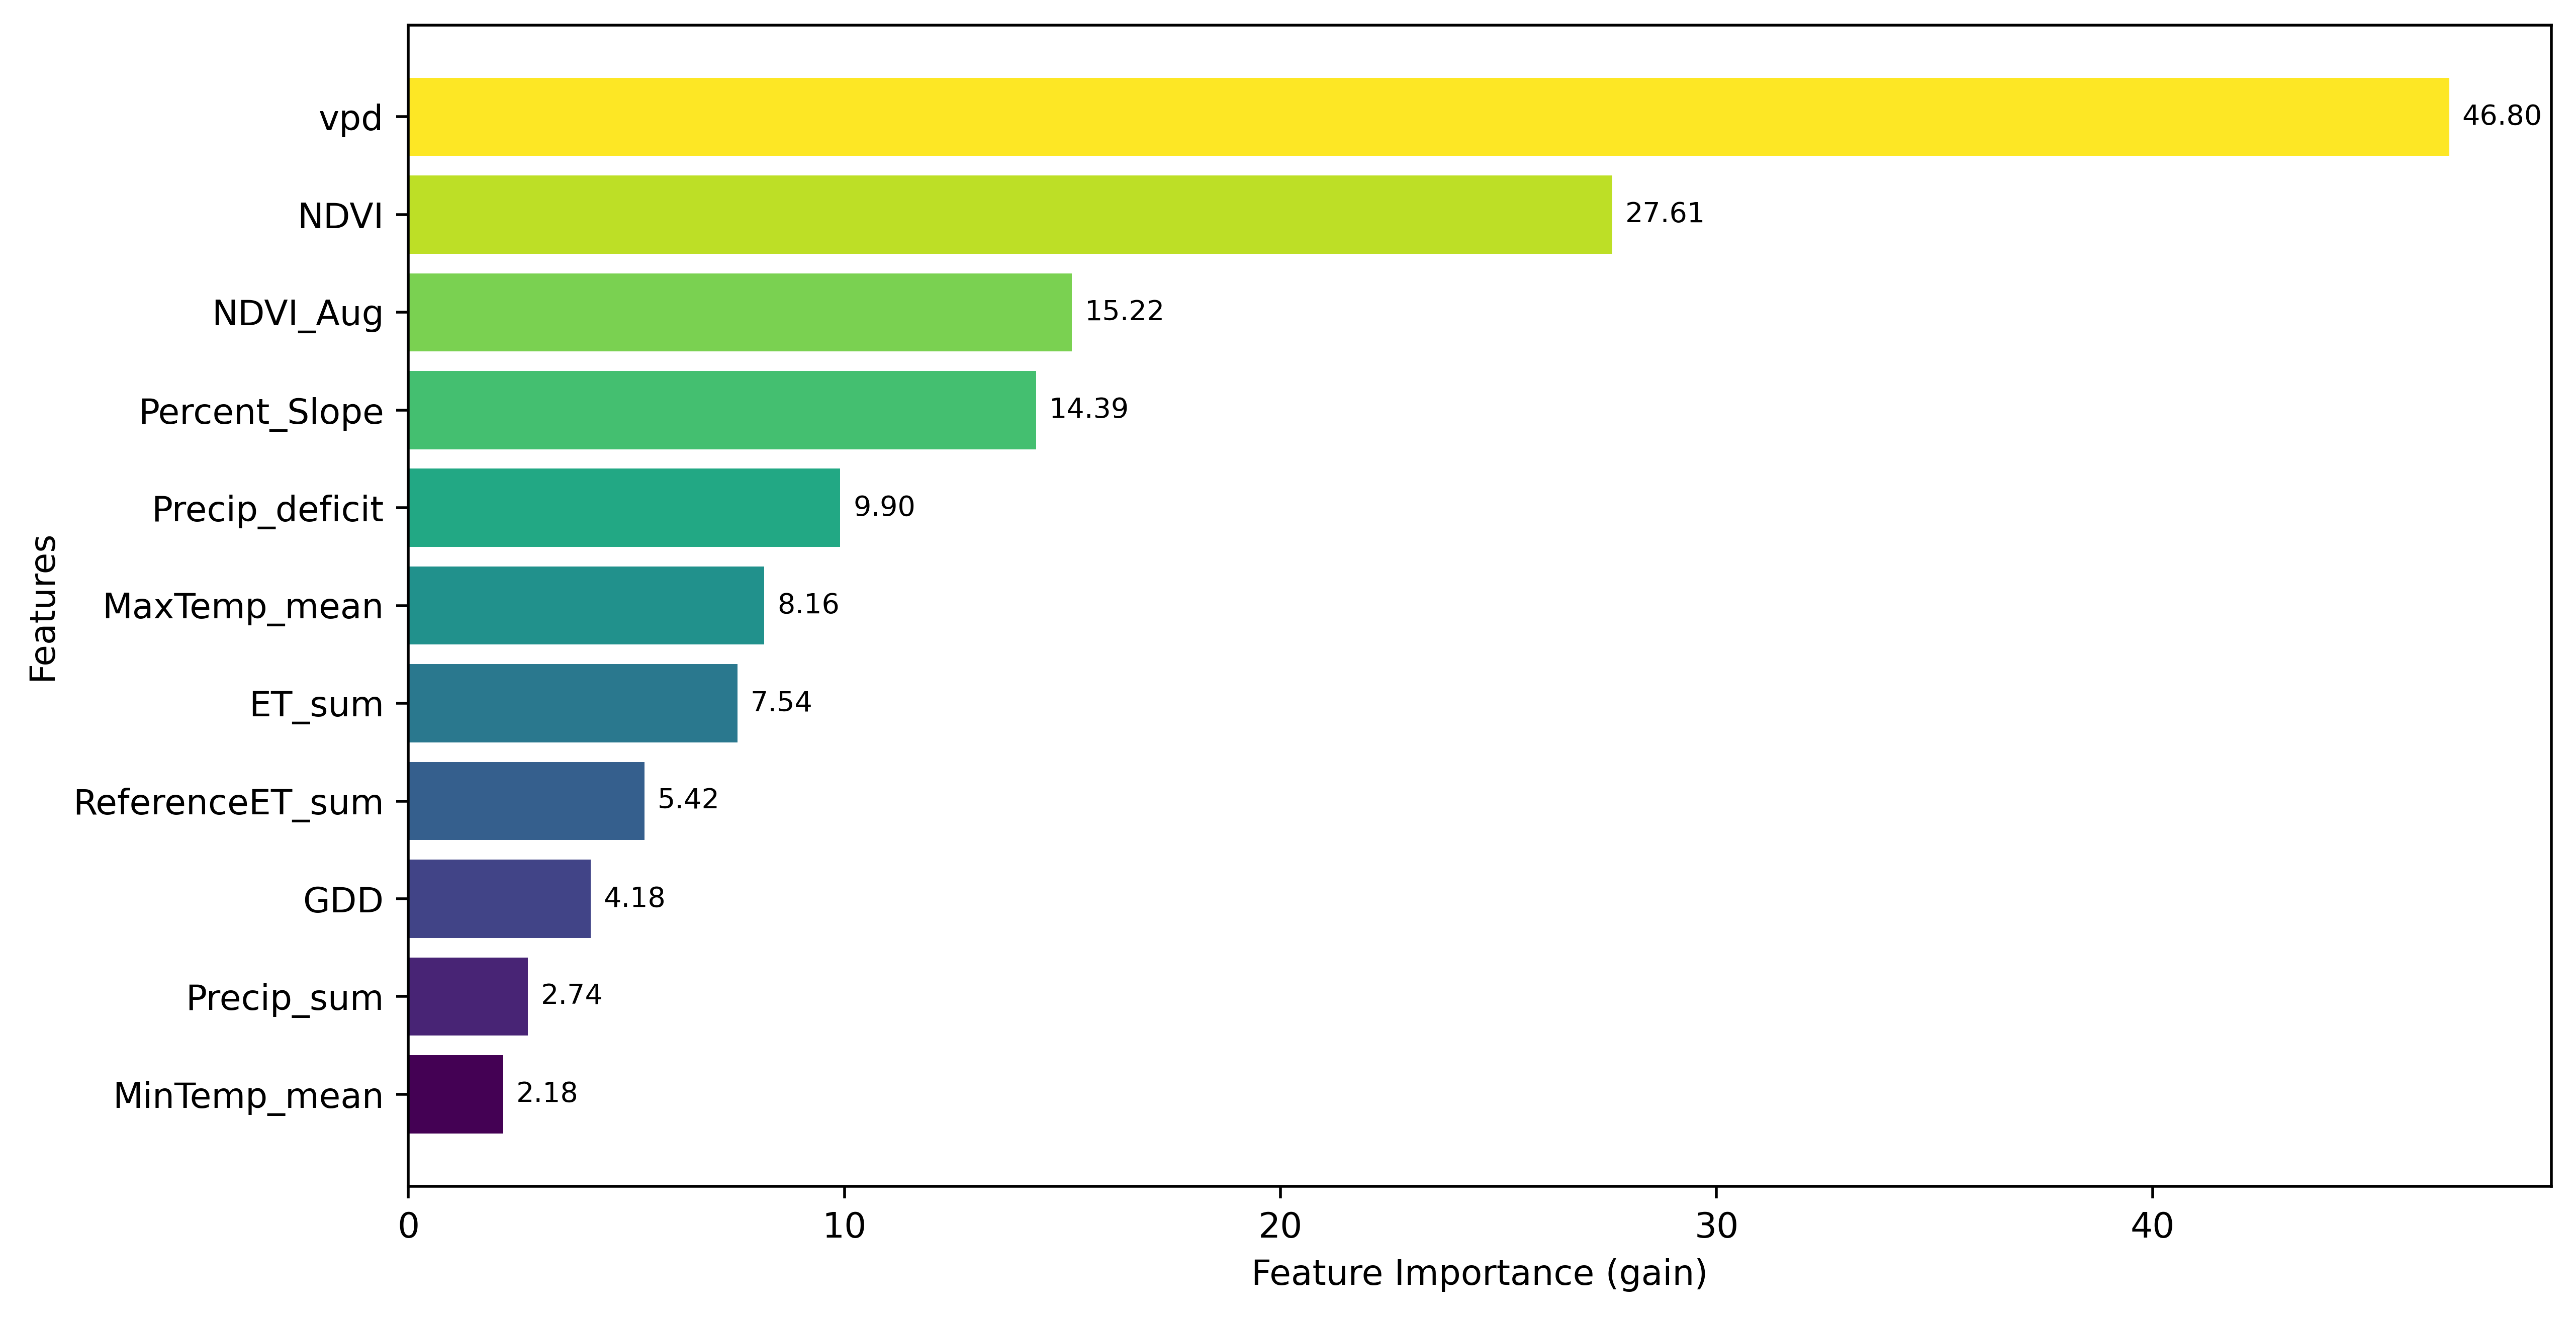

In [51]:
feature_importance_gain = final_xgb_model.get_booster().get_score(importance_type="gain")
sorted_feature_importance_gain = sorted(feature_importance_gain.items(), key=lambda x: x[1], reverse=False)
# Extract feature names and gain scores
feature_names_gain = [x[0] for x in sorted_feature_importance_gain]
gain_scores = [x[1] for x in sorted_feature_importance_gain]

# Define a colormap
num_features = len(feature_names_gain)
cmap = plt.cm.get_cmap(None, num_features)

# Create a bar plot of feature importance (gain) with custom colors
plt.figure(figsize=(11, 6))
bars = plt.barh(feature_names_gain, gain_scores, color=[cmap(i) for i in range(num_features)])
plt.xlabel('Feature Importance (gain)')
plt.ylabel('Features')

# Add annotations for values at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width()+.3, bar.get_y() + bar.get_height()/2, f'{gain_scores[i]:.2f}',
             va='center', ha='left', fontsize=8)

plt.show()

In [54]:
# Dictionary mapping original column names to short SHAP plot-friendly names
rename_dict = {
    'MinTemp_mean': 'Avg MinTemp',
    'MaxTemp_mean': 'Avg MaxTemp',
    'GDD': 'GDD',
    "vpd":"Mean VPD",
    'NDVI': 'Mean NDVI',
    'NDVI_Aug': 'Max NDVI Aug',
    'ET_sum': 'Total ET',
    'Precip_sum': 'Total Precip',
    'ReferenceET_sum': 'Total ET₀',
    'Tmp_excede33': "Temp above 33°C",
    'Percent_Slope': 'Slope (%)',
    'Precip_deficit': 'Precip Deficit'
}

# Rename the DataFrame columns
X_full_renamed = X_full.rename(columns=rename_dict)

### SHAP

we can use We
𝑋test too (or X_importance = X_test) in SHAP analysis, it will help us to  interpret how the model 
makes predictions (do the scoring on unseen data) on unseen data too. 


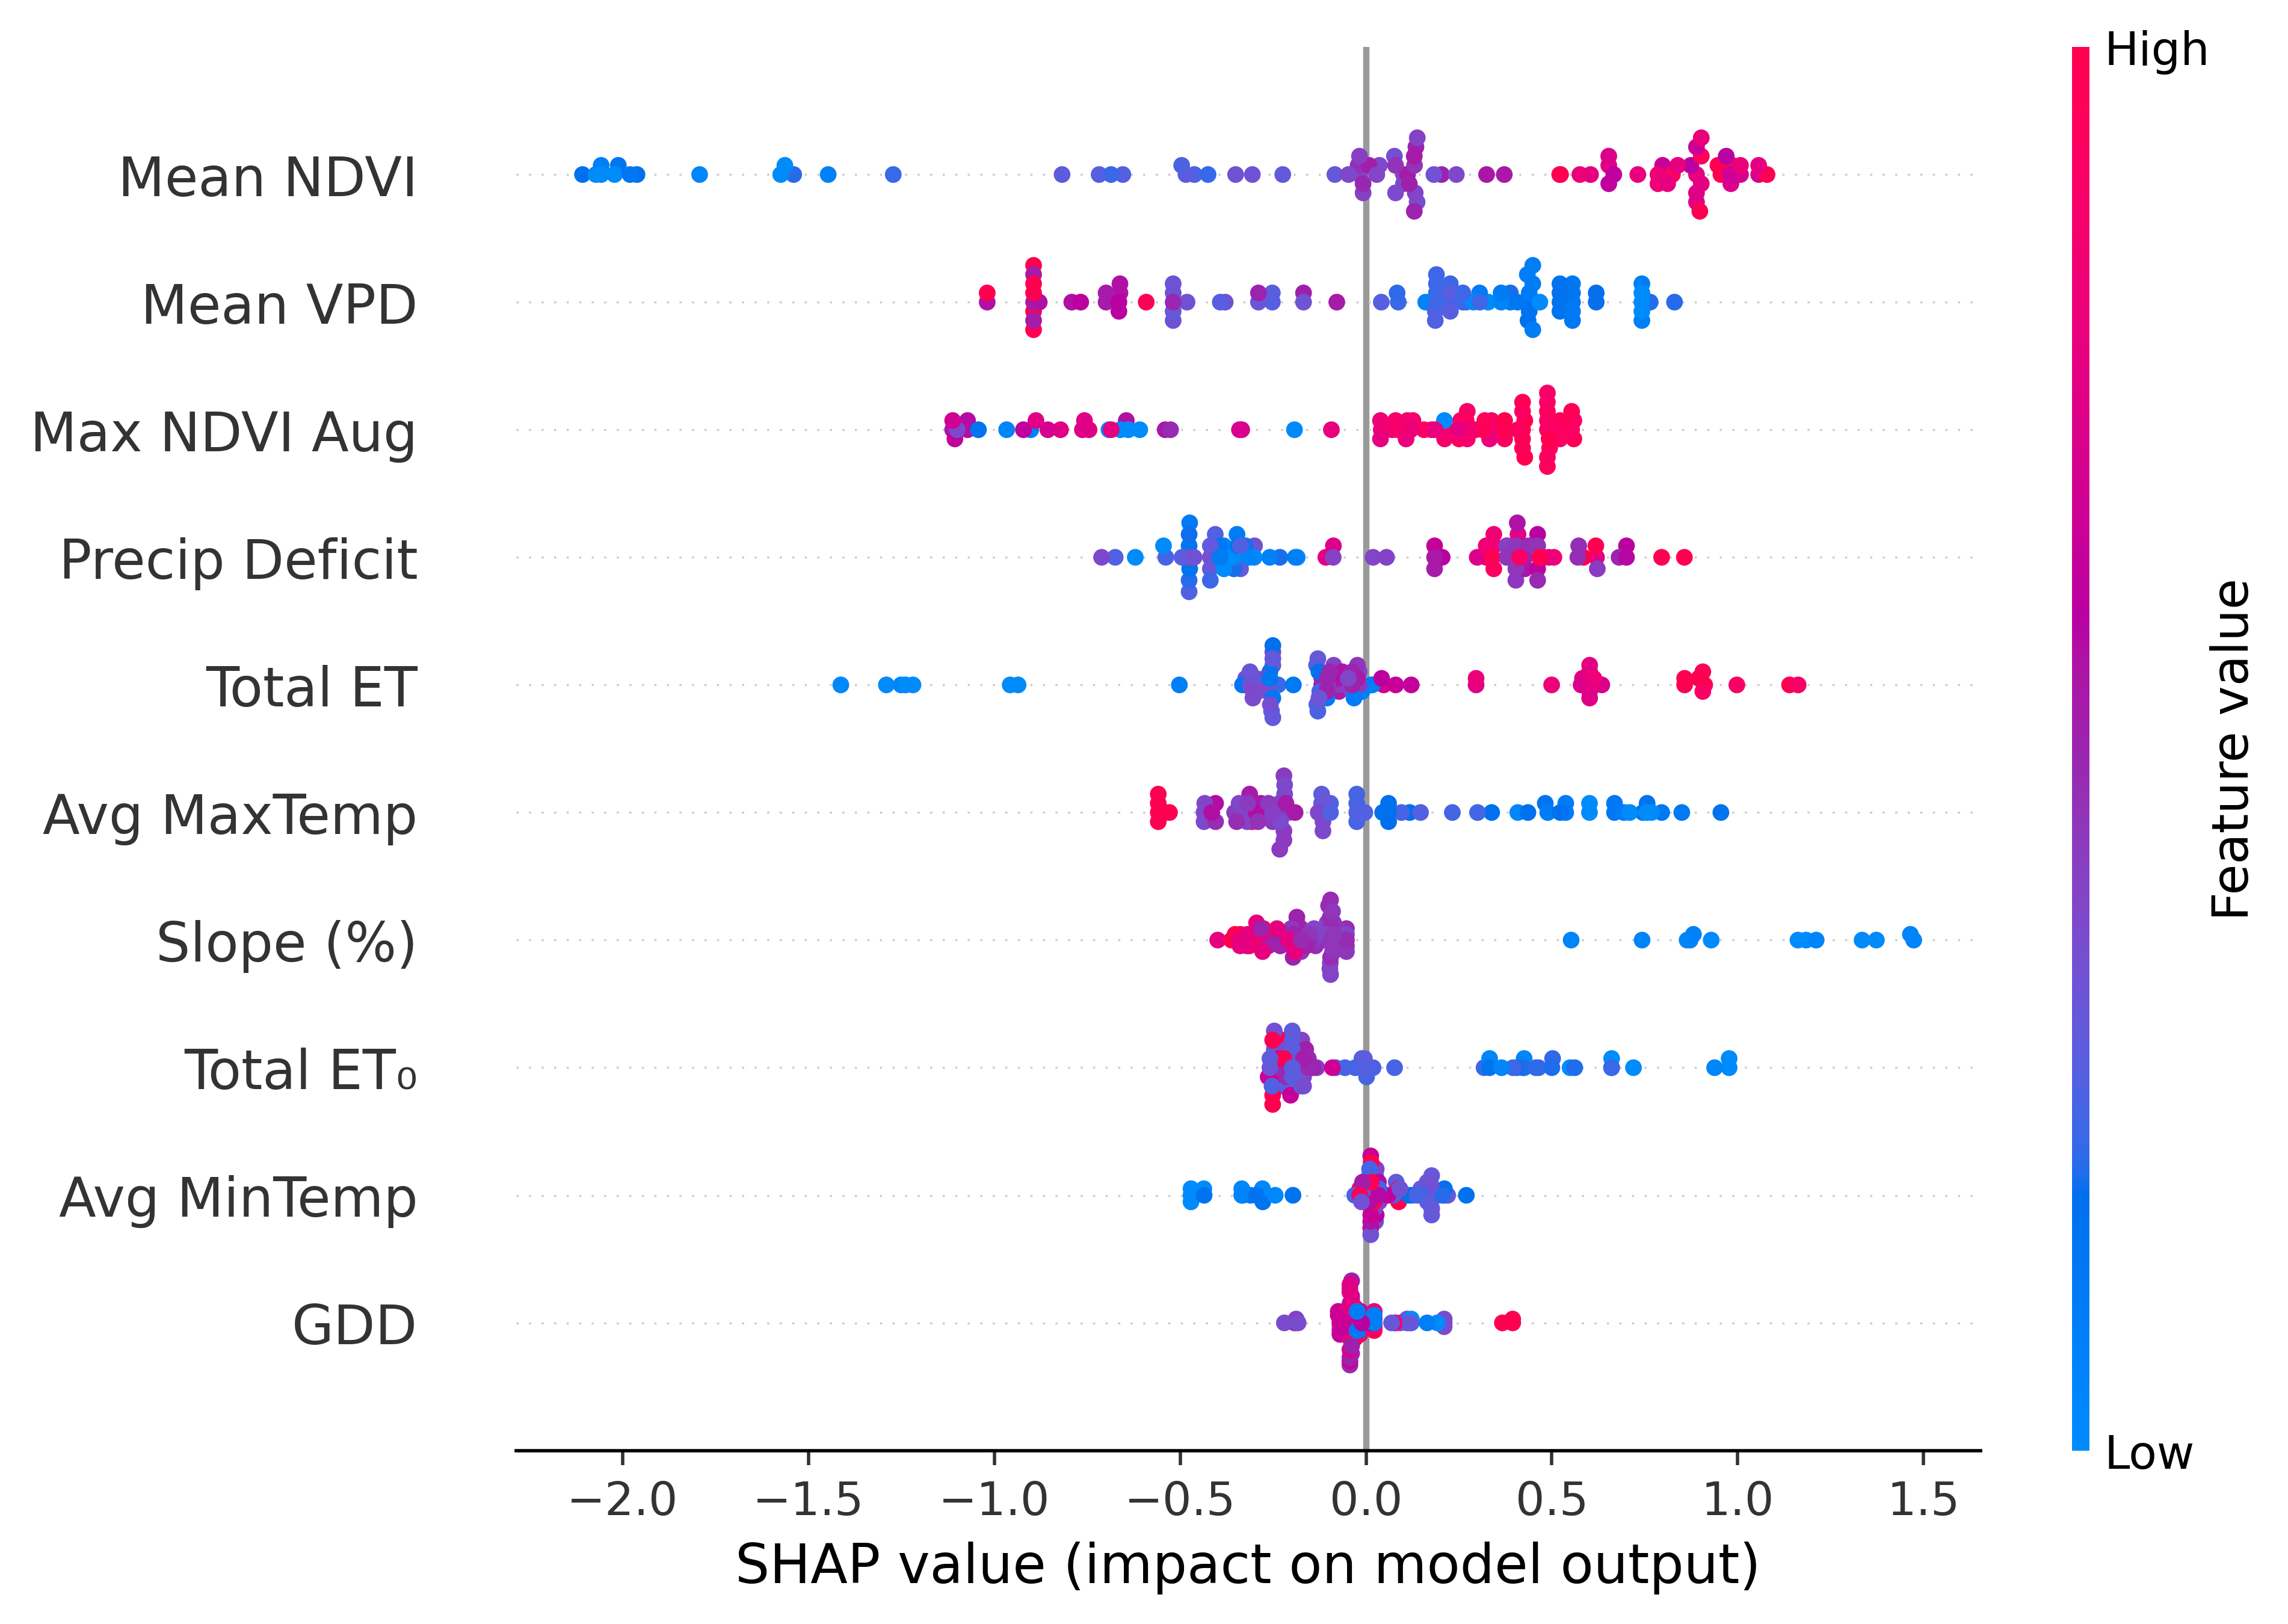

In [55]:
X_importance = X_full_renamed

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(final_xgb_model)
shap_values = explainer.shap_values(X_importance)

# Plot top 15 features
shap.summary_plot(shap_values, X_importance, max_display=10)